# Simulation functions

In [137]:
import os
import sys
newPath = os.path.dirname(os.path.dirname(os.path.abspath("")))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
import igraph as ig
import matplotlib.pyplot as plt
m = bi(platform='cpu')

jax.local_device_count 32


## Covariates simulation

In [138]:
import jax.numpy as jnp
import jax.random as jr
jnp.set_printoptions(precision=2,linewidth=200)

def symmetrize(array):
    return (array + array.T) / 2
    
def sim_grp_equal_prob(G, N):
    # Create a 1D array of ones with length G
    ones = jnp.ones((G,))

    # Normalize to get equal probabilities
    equal_probs = ones / G

    # Generate multinomial probabilities
    grp_prob = m.dist.multinomialprobs(equal_probs, 1, sample=True, shape=(N,))

    # Use vmap with jnp.argmax to sample indices
    return vmap(jnp.argmax)(grp_prob)

def sim_grp(N, Ngrp=2,gByGrp=jnp.array([1,3])):
    return [sim_grp_equal_prob(gByGrp[i],N) for i in range(len(gByGrp))]

def create_random_network(n, rate = 0.2, seed=0):
    """
    Create a random network adjacency matrix using the Erdős-Rényi model.
    
    Parameters:
        n (int): Number of nodes in the network.
        rate (float): ate parameter (mean of the distribution), must be >= 0.
        seed (int): Random seed for reproducibility.
        
    Returns:
        jax.numpy.ndarray: Adjacency matrix of the generated random network.
    """
    # Set the random seed for reproducibility
    key = jax.random.PRNGKey(seed)
    
    upper_tri = jax.random.poisson(key,lam = rate,  shape = (n, n))
    lower_tri = upper_tri
    
    # Make the matrix symmetric to represent an undirected graph
    m = upper_tri + lower_tri
    m = m.at[jnp.diag_indices(m.shape[0])].set(0)
    return m

def viz_network(network, block1 = None):
    
    # Convert the input data to NumPy arrays
    adj_matrix_np = np.array(network)
    if block1 is not None:
        block1_np = np.array(block1)
    else:
        block1_np = None


    # Create an igraph graph from the adjacency matrix
    G = ig.Graph.Adjacency((adj_matrix_np > 0).tolist())

    # Add weights to the edges if the adjacency matrix contains weights
    G.es['weight'] = adj_matrix_np[adj_matrix_np.nonzero()] / 4

    # Define the layout
    layout = G.layout_kamada_kawai()
    scale_factor = 20
    layout = [tuple(coord * scale_factor for coord in point) for point in layout]

    # Map the color array to specific colors
    color_map = {0: 'red', 1: 'green', 2: 'blue'}
    if block1_np is not None:
        node_colors = [color_map[block] for block in block1_np]
    else:
        node_colors = ['gray'] * len(G.vs)

    edge_colors = []
    for edge in G.es:
        # 'edge.source' gives the emitter node index for directed graphs.
        edge_colors.append(node_colors[edge.source])
    #G.es["color"] = edge_colors

    # Plot the graph
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ig.plot(G, layout=layout, 
            vertex_size=10, vertex_color=node_colors, 
            edge_width=G.es['weight'], target=ax,
            #edge_color=G.es["color"],
            edge_arrow_size=4, edge_curved = 0.2)

    # Display the plot
    plt.show()

def create_covariates(N=50, times=100,
b_ij_mean1 = 0.5, b_ij_sd1 = 0.5, b_ii_mean1 = 0.7, b_ii_sd1 = 1.5,
b_ij_mean = 0.02, b_ij_sd = 0.1, b_ii_mean = 0.4, b_ii_sd = 0.1,
print_network = False):
    # Network-----------------------------------------------------------
    ## Block ---------------------------------------
    blocks = sim_grp(N, Ngrp=2,gByGrp=jnp.array([1,3]))
    block0=blocks[0]
    block1=blocks[1]
    B0 = bi.net.block_model(block0,1, b_ij_mean = b_ij_mean1, b_ij_sd = b_ij_sd1, b_ii_mean = b_ii_mean1, b_ii_sd = b_ii_sd1,sample=True)
    B1 = bi.net.block_model(block1,3, b_ij_mean = b_ij_mean, b_ij_sd = b_ij_sd, b_ii_mean = b_ii_mean, b_ii_sd = b_ii_sd,sample=True)

    ### SR shape =  N individuals---------------------------------------
    focal_individual_predictors = m.dist.binomial(total_count = 1, logits = 0.5, sample=True, shape=(1,N)) # Fixed covariate
    target_individual_predictors=focal_individual_predictors
    sr =  bi.net.sender_receiver(focal_individual_predictors,target_individual_predictors,
                                 s_mu= -0.5, s_sd= 0.1, r_mu= 0, r_sd= 0.2,
                                 sample=True)

    ## Dyadic shape = N dyads-------------------------------------- 
    covDF = create_random_network(N, rate=0.1) # Fixed dyadic covariate
    covDF = jnp.where(covDF > 0, 1, 0) 
    dyadic_predictors =bi.net.mat_to_edgl(covDF)
    dr = bi.net.dyadic_effect(dyadic_predictors=dyadic_predictors, shape=(N,), sample=True)

    network=bi.net.edgl_to_mat(bi.poisson(jnp.exp(B0 + B1 + sr + dr),sample=True ), N)

    if print_network:
        viz_network(network, block1)

    # Covariates-----------------------------------------------------------
    time = jnp.arange(0,times)
    covF = focal_individual_predictors # Fixed covariate
    jnp.tile(covF[0,:], (times, 1)).T.shape

    # Time-varying covariate

    covV = bi.dist.poisson(5, sample=True, shape=(N,)) # time-varying covariate
    covV = vmap(lambda x: covV + x)(time).T
    covDV = vmap(lambda x: create_random_network(N, rate=0.3, seed=x))(time).transpose(1,2,0) # Time-varying dyadic covariate
    covDF = jnp.stack([covDF] * times, axis=2)

    return {
        'covF': covF[0,:],
        'covV': covV,
        'network': network,
        'covDF': covDF,
        'covDV': covDV
    }

def heatmap(array):
    # Convert to NumPy for Matplotlib
    data_np = jnp.array(array)  # Alternatively, use `data.to_numpy()`

    # Plot heatmap
    plt.imshow(data_np, cmap="viridis", aspect="auto")
    plt.colorbar(label="Value")
    plt.show()


To create covaraites just run ```covariates_data = create_covariates(N=N, times=times)```

## NBDA class
This class will store and adapt data for the NBDA model.

In [139]:
import pandas as pd
import jax
import jax.numpy as jnp
from functools import partial
from jax import vmap


class NBDA:

    def __init__(self,network,status):
        """
        Initialize an NBDA object with network and status arrays.

        Args:
            network (Array): A 2-dimensional array of shape (n, n) or a 4-dimensional array of shape (n, n, t, num_networks). 
                             If 2D, it is repeated across time. If 4D, it should be created by the user.
            status (Array): A 2-dimensional array of shape (n, t) representing the status of nodes over time.

        Returns:
            None
        """
        # Status 
        self.status=status
        self.n=status.shape[0]
        self.t=status.shape[1]

        ## Status at t-1
        self.status_i, self.status_j = self.convert_status(status)

        # Network
        self.network=None
        if len(network.shape)==2:
            self.convert_network(network)
        elif (len(network.shape)==4):
            self.network=network
        elif (len(network.shape)!=4):
            raise ValueError("Network must be a 2 (n, n) or 4 dimensional array (n, n, t, num_networks)")

        # Intercetps for the network
        self.intercept = jnp.ones(self.network.shape)

        # fixed nodal covariates
        self.covNF_i=None
        self.covNF_j=None

        # Time-varying nodal covariates
        self.covNV_i=None
        self.covNV_j=None

        # fixed dyadic covariates
        self.covDF=None

        # Time-varying dyadic covariates
        self.covDV=None

        # individual observed
        self.observed=None

        # Conatenated covariates
        self.D_social=None
        self.D_asocial=None

        # Names
        self.names=dict(intercept_asocial = 'intercept_asocial', intercept_social = 'intercept_asocial')

    def convert_network(self, network, names = None): # To be used only if there is a single network

        """
        Convert a single network array to a 4D array.

        Args:
            network (Array): A 2-dimensional array of shape (n, n).

        Returns:
            network: A 4-dimensional array of shape (n, n, t, 1) after repeating the network across time.
        """

        self.network=jnp.repeat(network[jnp.newaxis, :, :,jnp.newaxis], self.t, axis=0).transpose((1,2,0,3))

        if names is not None:
            if len(names)!=self.network.shape[3]:
                raise ValueError("The length of names must be equal to the number of networks.")
            self.names['network']=[name for name in names]
        return self.network


    def convert_status(self, status):#A 2-dimension arrray of (n,t)
        """
        Convert status array to lagged status arrays for i and j.

        Args:
            status (Array): A 2-dimensional array of shape (n, t).

        Returns:
            arrays_status_i (Array): A 3-dimensional array of shape (n, n, t) for i.
            arrays_status_j (Array): A 3-dimensional array of shape (n, n, t) for j.
             ! Both status are the lagged status (t-1) !
        """
        tmp=jnp.concatenate([jnp.zeros((self.n,1)),status[:,:-1]], axis=1)
        tmp2=jnp.array([tmp[:,i][:, None, None]* jnp.ones((self.n, self.n, 1)) for i in range(self.t)])
        tmp3=jnp.array([status[:,i][:, None]* jnp.ones((self.n,  1)) for i in range(self.t)])

        self.arrays_status_i = jnp.transpose(tmp2,(1,2,0,3))
        self.arrays_status_j = jnp.transpose(tmp2,(2,1,0,3))
        self.status = jnp.transpose(tmp3,(1,0,2))
        return self.arrays_status_i, self.arrays_status_j

    def covNF_dims(self,df, n, t, num_variables):
        """
        Convert fixed nodal covariates into 4D arrays.

        Args:
            df (DataFrame or Array): A 2-dimensional array of shape (n, num_variables).
            n (int): Number of nodes.
            t (int): Number of time points.
            num_variables (int): Number of covariates.

        Returns:
            result_array_i (Array): A 4-dimensional array of shape (n, n, t, num_variables) for i.
            result_array_j (Array): A 4-dimensional array of shape (n, n, t, num_variables) for j.
        """
        # Create arrays using broadcasting
        arrays = jnp.array([df[:, var_idx].reshape(-1, 1) * jnp.ones((n, n, t)) for var_idx in range(num_variables)])

        # Transpose arrays to get the required shape
        result_array_j = jnp.transpose(arrays, (1, 2, 3, 0))  # (n, n, t, num_variables)
        result_array_i = jnp.transpose(arrays, (2, 1, 3, 0))  # (n, n, t, num_variables)

        return result_array_i, result_array_j

    def convert_covNF(self, df, n, t, num_variables):
        """
        Convert fixed nodal covariates into 4D arrays.

        Args:
            df (DataFrame or Array): A 2-dimensional array of shape (n, num_variables).
            n (int): Number of nodes.
            t (int): Number of time points.
            num_variables (int): Number of covariates.

        Returns:
            tuple: A tuple of two 4-dimensional arrays (result_array_i, result_array_j).
        """
        if isinstance(df, pd.DataFrame):
            df = jnp.array(df)
        else:
            if len(df)>2:
                raise ValueError("covariates must be a data frame or a 2-dimensional array")

        return  self.covNF_dims(df, n, t, num_variables)

    def import_covNF(self, df, names=None):
        """
        Import fixed nodal covariates.

        Args:
            df (DataFrame or Array): A 2-dimensional array of shape (n, num_variables).

        Returns:
            tuple: A tuple of two 4-dimensional arrays (covNF_i, covNF_j).
        """
        self.covNF_i, self.covNF_j = self.convert_covNF(df, self.n, self.t, df.shape[1])

        if names is not None:
            if len(names)!=self.covNF_i.shape[3]:
                raise ValueError("The length of names must be equal to the number of variables.")
            self.names['covNF']=[name for name in names]

    def convert_covNV(self, covV):
        """
        Convert time-varying nodal covariates into 4D arrays.

        Args:
            covV (Array): A 3-dimensional array of shape (num_variables, n, t).

        Returns:
            tuple: A tuple of two 4-dimensional arrays (result_array_i, result_array_j).
        """
        arrays=jnp.array([covV[i,:, ].T[:, None, :]* jnp.ones((1, self.n, 1)) for i in range(covV.shape[0])])
        result_array_i = jnp.transpose(arrays, (2, 3, 1, 0))  # (n, n, t, num_variables)
        result_array_j = jnp.transpose(result_array_i, (1, 0, 2, 3))
        
        return result_array_i, result_array_j

    def import_covNV(self, covV, names = None): #covV need to be a 3 dimensional array of shape (num_var, n, t)i.e. A list of matrices of time-varying covariates
        self.covNV_i, self.covNV_j = self.convert_covNV(covV)
        if names is not None:
            if len(names)!=self.covNV_i.shape[3]:
                raise ValueError("The length of names must be equal to the number of variables.")
            self.names['covNV']=[name for name in names]

    def import_covDF(self, covDF, names = None):
        """
        Import fixed dyadic covariates.

        Args:
            covDF (Array): A 2-dimensional array of shape (n, n) or a 3-dimensional array of shape (n, n, num_dyads).

        Returns:
            Array: A 4-dimensional array of shape (n, n, t, num_variables) if input is 3D, otherwise shape (n, n, t, 1).
        """
        if len(covDF.shape)==2:
            self.covDF = jnp.repeat(covDF[jnp.newaxis, :, :,jnp.newaxis], self.t, axis=0).transpose((1,2,0,3))

        else:
            self.covDF = jnp.array([covDF[i,:, :,None]*jnp.ones((self.n, self.n, self.t)) for i in range(covDF.shape[0])]).transpose((1,2,3,0))
 
        if names is not None:
            if len(names)!=self.covDF.shape[3]:
                raise ValueError("The length of names must be equal to the number of variables.")
            self.names['covDF']=[name for name in names]

    def import_covDV(self, covDV, names = None):
        """
        Import time-varying dyadic covariates.

        Args:
            covDV (Array): A 3-dimensional array of shape (n, n, t) or a 4-dimensional array of shape (n, n, t, num_dyadics_effects).

        Returns:
            Array: A 4-dimensional array of shape (n, n, t, num_variables).
        """
        if len(covDV.shape)==3:# A list of matrices of a single time-varying covariate
            self.covDV = covDV[:, :, :,jnp.newaxis]


        if len(covDV.shape)==4:# A ist of list of matrices of a single time-varying covariate
            self.covDV = jnp.array([covDV[i,:, :,None]*jnp.ones((self.n, self.n, self.t)) for i in range(covDF.shape[0])]).transpose((1,2,3,0))

        if names is not None:
            if len(names)!=self.covDV.shape[3]:
                raise ValueError("The length of names must be equal to the number of variables.")
            self.names['covDV']=[name for name in names]

    def stack_cov(self):
        """
        Stack all covariates into a dictionary.

        Returns:
            dict: A dictionary containing all covariates.
        """
        tmp=dict(
            intercept = self.intercept,
            status = self.status,
            status_i = self.status_i, 
            status_j = self.status_j,
            covNF_j = self.covNF_i,
            covNF_i = self.covNF_j,
            covNV_i = self.covNV_i,
            covNV_j = self.covNV_j,
            covDF = self.covDF,
            covDV = self.covDV,
            network = self.network,
            observed = self.observed,
        )
        return {k: v for k, v in tmp.items() if v is not None}

    def get_cov(self):
        """
        Get all covariates in the NBDA object.

        Returns:
            tuple: A tuple of two arrays (D_social, D_asocial).
        """
        
        objects = self.stack_cov()
        D_social = []
        D_asocial = []
        for k in objects.keys():
            if k not in ['status', 'status_i', 'status_j', 'network']:
                if k is not None:   
                    if k in ['intercept', 'covNF_i', 'covNV_i']: 
                        D_social.append(objects[k])
                        D_asocial.append(objects[k][0,:,:,:],)                        
                    else:
                        D_social.append(objects[k])                        
                    

        self.D_social = jnp.concatenate(D_social, axis=-1)
        self.D_asocial = jnp.concatenate(D_asocial, axis=-1)

    
    

    @staticmethod
    def sum_cov_effect(n,t,stacked_betas, stacked_cov):
        """
        Calculate the sum of covariate effects.

        Args:
            n (int): Number of nodes.
            t (int): Number of time points.
            stacked_betas (Array): An array of coefficients.
            stacked_cov (Array): An array of covariates.

        Returns:
            Array: A 3-dimensional array of shape (n, n, t) representing the sum of covariate effects.
        """
        res=jnp.zeros((n,n,t))
        for a in range(len(stacked_cov)):
            res=res.at[:,:,:].set(
            res[:,:,:] +  
            jnp.sum(stacked_cov[a]*stacked_betas[a],axis=3))
    
        return res

    # We can add individual observation information in the same forme as  an input time varying cov
    # We can add multiple behaviors acquisition in the form of a (n,n,t,num_behaviors)
    # Random variable to add
    # Do we add inverse of status_i? As we need net filter by j status that are informed (net*status_j) and cov array filtered by i status that are zero (cov*(1-status_i))


## Diffusion simulations


In [140]:
import ipdb
@jax.jit
def inv_logit2(x):
    """
    Modified inverse logit function scaling between 0 and 1.
    """
    return (bi.inv_logit(x) - 0.5) * 2


In [141]:
import random as random2

def diffusion(data, alpha_social, alpha_asocial):
    D_social = data.D_social
    D_asocial = data.D_asocial
    informed = jnp.zeros((data.n,  data.t), dtype=int)

    # Asocial learning only at t = 0-----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], alpha_asocial, axes=(-1, 0))
    theta = bi.link.inv_logit(R_asocial)


    # Informed update at t = 0-----------------------
    informed = informed.at[:,0].set(bi.dist.binomial(probs = theta, sample=True, seed = random2.randint(0,10000)))


    for t in range(1,data.t):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], alpha_social, axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)        
        attention_weigthed_network = phi*data.network[:,:,t,0]
        tmp = np.tensordot(attention_weigthed_network[:,:], informed[:,t-1], axes=(-1, 0))
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], informed[:,t-1], axes=(-1, 0)))
        #status_network = jnp.tensordot(data.network[:,:,t,0],  informed[:,t-1], axes=(-1, 0))
        #attention_weigthed_network = phi[0,:]*status_network
        #social_influence_weight = inv_logit2(attention_weigthed_network)

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], alpha_asocial, axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)

        # Informed update at t!= 0-----------------------
        p = theta + (1-theta)*social_influence_weight

        informed =  informed.at[:,t].set(jnp.where(informed[:, t-1] == 1, 1, bi.dist.binomial(probs = p, sample=True, seed = random2.randint(0,10000))))

    return informed


## NBDA Model
This model should adapt to NBDA class stored information.
In order to implement time varying coefficients we need to define a function that takes the $V$ covariates and $T$ time points and returns the coefficients. All coefficents of the model need this structure.

In [373]:
def coefficients(V, T,
                mu_mu =  0,
                mu_sigma = 1,
                sigma_mu = 1,
                sample = False,
                name = 'betas_soc'):
    """
    Generates time-varying coefficients using hierarchical normal distributions.

    Args:
        V (int): Number of coefficients.
        T (int): Number of time points.
        mu_mu (float, optional): Mean of the Mu_betas distribution. Defaults to 0.0.
        mu_sigma (float, optional): Mean of the Sigma_betas distribution. Defaults to 1.
        sigma_mu (float, optional): Standard deviation of the Mu_betas distribution. Defaults to 1.
        name (str, optional): Name for identification. Defaults to 'betas_soc'.

    Returns:
        Tensor: A tensor of shape (T, V) representing time-varying coefficients.

    Distribution Details:
        - Mu_betas: Normal distribution with mean=mu_mu and std=sigma_mu
        - Sigma_betas: Normal distribution with mean=mu_sigma and std=sigma_sigma
        - betas: Normal distribution with mean=Mu_betas and std=Sigma_betas
    """

    Mu_betas = bi.dist.normal(mu_mu, mu_sigma, shape = (V,), sample=sample, name='Mu_'+name)
    Sigma_betas = bi.dist.exponential(sigma_mu, shape = (V,), sample=sample, name='Sigma_'+name)
    betas = bi.dist.normal(Mu_betas, Sigma_betas, shape = (T,), sample=sample, name='betas_'+name).reshape(T, V)
    return betas

coefficients(1, 10, sample = True) # 1 variables 10 time points

Array([[-0.32],
       [-0.63],
       [ 0.78],
       [-0.1 ],
       [-0.16],
       [-0.41],
       [ 0.44],
       [-0.02],
       [-0.16],
       [-0.68]], dtype=float64)

### Model without covariates

In [ ]:
def model(D_asocial, D_social, status, network, new = True):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    if new:

        # Priors for social effect covariates
        soc = coefficients(1, T, mu_mu =  0, mu_sigma = 5, sigma_mu = 1, name = 'alpha_soc')

        # Priors for asocial effect covariates
        asoc = coefficients(1,  T, mu_mu =  0, mu_sigma = 5, sigma_mu = 1, name = 'alpha_asoc')

        # Asocial learning for time t = 0-----------------------
        R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc[0, :].reshape(1,), axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)
        lk = lk.at[:,0].set(theta)

    else:
        # Priors for social effect covariates
        soc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='soc')

        # Priors for asocial effect covariates
        asoc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='asoc')
        # Asocial learning -----------------------
        print('D_asocial shape')
        print(D_asocial[:,0,:].shape)
        print('asoc shape')
        print(asoc.shape)
        R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
        print('R_asocial shape')
        print(R_asocial.shape)
        theta = bi.link.inv_logit(R_asocial)
        print('theta shape')
        print(theta.shape)
        lk = lk.at[:,0].set(theta)


    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc[t, :].reshape(1,), axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))
        #status_network = jnp.tensordot(network[:,:,t,0], status[:,t-1], axes=(-1, 0))
        #attention_weigthed_network = phi[0,:]*status_network
        #social_influence_weight = inv_logit2(attention_weigthed_network)

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc[t, :].reshape(1,), axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)
        
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])

In [144]:
def model2(D_asocial, D_social,
           status,status_i, status_j , 
           network):
    N = status.shape[0]
    T = status.shape[1]

    # Priors for social effect covariates
    soc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_soc')

    # Priors for asocial effect covariates
    asoc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_asoc')

    ## Social learning-----------------------
    social_influence_weight = inv_logit2(jnp.sum(bi.link.inv_logit(jnp.expand_dims(jnp.tensordot(D_social, soc, axes=(-1, 0)), axis = -1))*network*status_j, axis = 1))

    ### Asocial learning -----------------------
    theta = bi.link.inv_logit(jnp.expand_dims(jnp.tensordot(D_asocial, asoc, axes=(-1, 0)), axis = -1))#theta = bi.link.inv_logit(R_asocial)

    # Update probabilities of learning based on individuals status ------------------
    ## Informed update-----------------------
    lk = jnp.where(status_i == 1, jnp.nan, theta + (1-theta)*social_influence_weight)  # Status_i need to be of the same shape as 
    lk = lk.at[:,0,:].set(theta[0,0,0])## Informed update at t== 0-----------------------

    ## Remove individuals once they learned form log probability computation-----------------------
    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status)


## Plot posterior distribution and simulated data

In [145]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import random
import math

def generate_random_hex_color():
    number = random.randint(0, 0xFFFFFF)
    return f"#{number:06X}"

def plot_distributions(posteriors , true_values = dict(alpha_asoc=-5, alpha_soc=1), by_param=False):
    parameters = list(posteriors.keys())
    
    if by_param:
        # Calculate number of rows and columns needed
        n_params = 0
        newParam = []
        for a in parameters:
            if posteriors[a].size > 1:
                n_params += 1
                newParam.append(a)

        parameters = newParam
        
        # Limit columns to between 1 and 3
        if n_params <= 1:
            n_cols = 1
        elif n_params <= 3:
            n_cols = n_params
        else:
            n_cols = 3       

            
        # Calculate number of rows based on n_params and n_cols
        n_rows = math.ceil(n_params / n_cols)
        
        # Create a figure with subplots
        if n_params == 1:
            fig, axes = plt.subplots(1, 1, figsize=(15, 10))
            # Convert single axis to array to make indexing consistent
            axes = np.array([axes])
        else:
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
            # Ensure axes is always a 2D array for consistent indexing
            if n_rows == 1:
                axes = axes.reshape(1, -1)
        
        fig.tight_layout()
    else:
        plt.figure(figsize=(10, 6))
    
    legend_handles = []
    
    for param in parameters:
        if by_param:
            # Calculate index for subplot positioning
            idx = parameters.index(param)
            row = idx // n_cols
            col = idx % n_cols
            
            # Access the appropriate subplot
            if n_params == 1:
                ax = axes[0]
            else:
                ax = axes[row, col]
        else:
            ax = plt.gca()

        mean = posteriors[param].mean(axis=0)
        std = posteriors[param].std(axis=0)
        
        if mean.shape == ():
            color = generate_random_hex_color()
            
            # Create a histogram to get the distribution data
            n, bins, patches = plt.hist(posteriors[param], bins=50, density=True, alpha=0.0)
            
            # Add true value offset
            n = n + true_values[param]
            density = n
            
            # Center the distribution
            center_in_density = density.mean()
            density_shifted = density - center_in_density
            
            # Scale the distribution
            scale_factor = 0.3
            density_scaled = density_shifted * scale_factor
            
            # Shift to true value position
            density_final = density_scaled + true_values[param]
            
            # Get bin centers
            bin_centers = (bins[1:] + bins[:-1]) / 2
            
            # Plot the distribution
            if by_param:
                ax.plot(n, bin_centers, color=color)
                ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
            else:
                ax.plot(density_final, bin_centers, color=color)
                ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
            
            # Add legend handle
            legend_handle = mlines.Line2D([], [], color=color, marker='o', linestyle='-', label=f"{param}")
            legend_handles.append(legend_handle)
            
            # Add labels and title
            ax.set_xlabel(f" True Value of Parameter {param}")
            ax.set_ylabel(f" Posterior distribution of Parameter {param}")
            ax.set_title(f'Distribution of {param}')
            if by_param:
                # Set individual y-axis limits for each subplot
                y_min = min(posteriors[param][:, a])
                y_max = max(posteriors[param][:, a])
                padding = 0.1 * (y_max - y_min)
                ax.set_ylim(y_min - padding, y_max + padding)           
            
            if not by_param:
                ax.grid(False)
        else:
            color = generate_random_hex_color()
            length = len(mean)
            
            for a in range(length):
                color = generate_random_hex_color()
                
                # Create a histogram to get the distribution data
                n, bins, patches = plt.hist(posteriors[param][:, a], bins=50, density=True, alpha=0.0)
                
                # Add true value offset
                n = n + true_values[param][a]
                density = n
                
                # Center the distribution
                center_in_density = density.mean()
                density_shifted = density - center_in_density
                
                # Scale the distribution
                scale_factor = 0.3
                density_scaled = density_shifted * scale_factor
                
                # Shift to true value position
                density_final = density_scaled + true_values[param][a]
                
                # Get bin centers
                bin_centers = (bins[1:] + bins[:-1]) / 2
                
                # Plot the distribution
                if by_param:
                    ax.plot(n, bin_centers, color=color)
                    ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
                else:
                    ax.plot(density_final, bin_centers, color=color)
                    ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
                
                # Add legend handle
                legend_handle = mlines.Line2D([], [], color=color, marker='o', linestyle='-', label=f"{param}_{a}")
                legend_handles.append(legend_handle)
                
                # Add labels and title
                ax.set_xlabel(f" True Value of Parameter {param}_{a}")
                ax.set_ylabel(f" Posterior distribution of Parameter {param}_{a}")
                ax.set_title(f'Distribution of {param} ({a})')

                if by_param:
                    # Set individual y-axis limits for each subplot
                    y_min = min(posteriors[param][:, a])
                    y_max = max(posteriors[param][:, a])
                    padding = 0.1 * (y_max - y_min)
                    ax.set_ylim(y_min - padding, y_max + padding)

                if not by_param:
                    ax.grid(False)
    
    if not by_param:
        plt.xlabel(f" True Values ")
        plt.ylabel(f" Posterior distribution")
        plt.grid(False)
        plt.axis('tight')
        plt.legend(handles=legend_handles)
        plt.show()
    else:
        for ax in axes.ravel():
            if not ax.has_data():
                ax.axis('off')
        plt.axis('tight')
        plt.tight_layout()
        plt.show()

# Fro further details on the posterior distributions, we can plot the KDE of each parameter
def kde(array, original_value, name = None, mean = True):
    if mean :
        estimated_mean = array.mean()
    else:
        estimated_mean = jnp.median(array)
    original_value = original_value
    sns.histplot(array, kde=True, bins = 100)
    plt.axvline(original_value, color='r', linestyle='dashed', linewidth=1, label='Simulated value')
    plt.axvline(estimated_mean, color='g', linestyle='dashed', linewidth=1, label='Estimated value')
    plt.xticks([estimated_mean, original_value], 
           [f'{estimated_mean:.2f}', f'{original_value:.2f}'])
    if name is not None:
        plt.title(f'Posterior distribution  vs simulated value for {name}')
    else:
        plt.title(f'Posterior distribution  vs simulated value')
    plt.show()

def params_kde(m, alpha_asocial, alpha_social):
    original_values = [alpha_asocial[0].tolist(), alpha_social[0].tolist()] + alpha_asocial[1:].tolist() + alpha_social[1:].tolist()
    count = 0
    for k in m.posteriors.keys():
        kde(m.posteriors[k][:,0], original_values[count], name=k)
        plt.close()
        count += 1



# Running a single simulation 
No covariates, only asocial and social intercept.

In [350]:
asoc = bi.dist.normal(0, 5, shape = (1,), sample=True, name='alpha_soc')
print(nbda.D_asocial[:,0,:].shape)
print(asoc.shape)
R_asocial = jnp.tensordot(nbda.D_asocial[:,0,:], asoc, axes=(-1, 0))    
R_asocial.shape

(200, 1)
(1,)


(200,)

In [375]:
asoc2 = coefficients(1 , 100, name = 'alpha_soc', sample = True)
print(asoc2.shape)
R_social =  jnp.tensordot(nbda.D_asocial[:,0,:], asoc2[0,:] , axes=(-1, 0))    
R_social.shape

(100, 1)


(200,)

In [ ]:
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1])
alpha_asocial =jnp.array([-5])
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

nbda=NBDA(covariates_data['network'], status) 
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status, new = True)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=alpha_asocial, alpha_soc=alpha_social), by_param=False)

Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32
D_asocial shape
(200, 1)
asoc shape
(100, 1)
R_asocial shape
(200,)
theta shape
(200,)
D_asocial shape
(200, 1)
asoc shape
(100, 1)
R_asocial shape
(200,)
theta shape
(200,)


  0%|          | 0/2000 [00:00<?, ?it/s]

D_asocial shape
(200, 1)
asoc shape
(100, 1)
R_asocial shape
(200,)
theta shape
(200,)


warmup:   2%|▏         | 31/2000 [00:40<20:02,  1.64it/s, 63 steps of size 6.59e-02. acc. prob=0.74]   

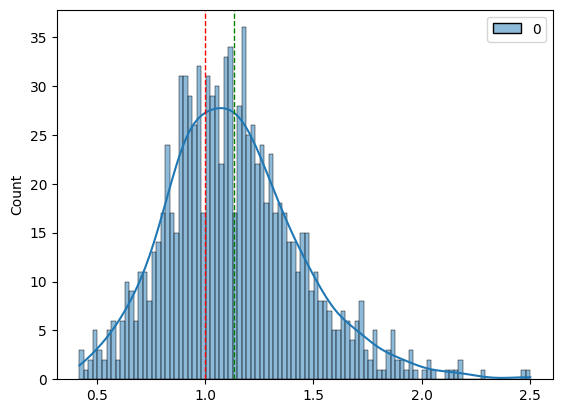

In [15]:
m.posteriors['alpha_soc'].mean()
m.posteriors['alpha_soc'].std()
sns.histplot(m.posteriors['alpha_soc'], kde=True, bins = 100)
plt.axvline(alpha_social, color='r', linestyle='dashed', linewidth=1)
plt.axvline(m.posteriors['alpha_soc'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.show()

jax.local_device_count 32


  0%|          | 0/2000 [00:00<?, ?it/s]2025-03-04 15:32:18.694450: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %multiply.176 = f64[200,200,100,1]{3,2,1,0} multiply(f64[200,200,100,1]{3,2,1,0} %constant.628, f64[200,200,100,1]{3,2,1,0} %constant.629)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-03-04 15:32:33.735720: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 16.041372374s
Constant folding an instruction is taking > 1s:

  %multiply.176 = f64[200,200,100,1]{3,2,1,0} multiply(f64[200,200,100,1]{3,2,1,0} %constant.628, f64[200,200,100,1]{3,2

Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -4.84  0.18     -5.12      -4.55       0.01     0.00    645.94   
alpha_soc[0]   1.15  0.33      0.62       1.66       0.01     0.01    586.46   

               ess_tail  r_hat  
alpha_asoc[0]    614.00    NaN  
alpha_soc[0]     372.78    NaN  


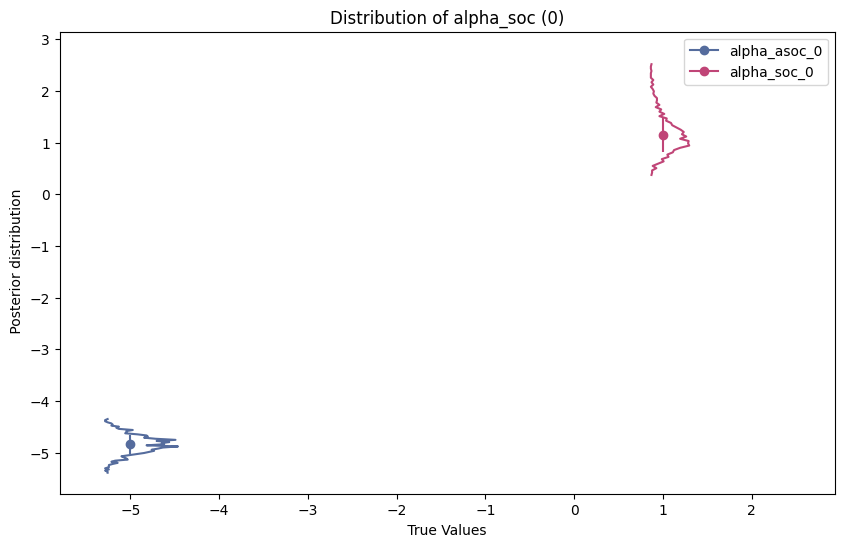

In [ ]:
## Run model to recover parameters
#m = bi()
#m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, 
#                     status_i=nbda.status_i[:,0, :,:], status_j =nbda.status_j, 
#                     network = nbda.network, status = nbda.status)
#m.run(model2, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
#summary = m.summary(kind = 'all')
#print("Estimated parameters")
#print(summary)#
## Plot results
#plot_distributions(m.posteriors,  dict(alpha_asoc=alpha_asocial, alpha_soc=alpha_social), by_param=False)

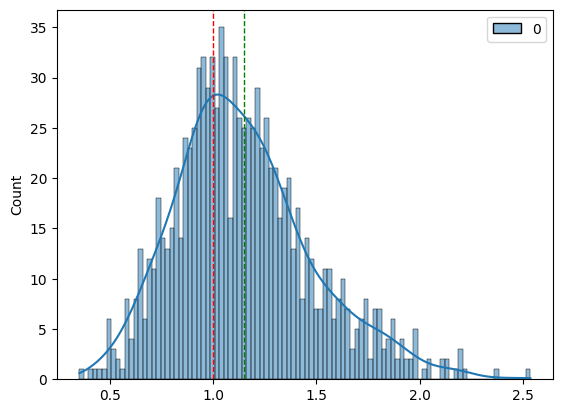

In [ ]:
#m.posteriors['alpha_soc'].std()
#sns.histplot(m.posteriors['alpha_soc'], kde=True, bins = 100)
#plt.axvline(alpha_social, color='r', linestyle='dashed', linewidth=1)
#plt.axvline(m.posteriors['alpha_soc'].mean(), color='g', linestyle='dashed', linewidth=1)
#plt.show()


# Main simulation function

This function runs the simulation as shown in the previous section and returns:

* The simulated data
* The true parameters
* The estimated parameters

In [10]:
import gc
def main(N = 100, times = 30, alpha_social = jnp.array([-10]), alpha_asocial = jnp.array([-1]),
         stop_when_informed = False, print_network= False, print_status = False):
    """Main simulation function

    Args:
        N (int, optional): Number of individuals. Defaults to 100.
        times (int, optional): Number of time steps. Defaults to 30.
        alpha_social (jnp.array, optional): Coefficients for social effect covariates. Defaults to jnp.array([-10]).
        alpha_asocial (jnp.array, optional): Coefficients for asocial effect covariates. Defaults to jnp.array([-1]).
    """

    covariates_data = create_covariates(N=N, times=times, print_network= True,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'
    nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
    nbda.get_cov()

    # Set simulation parameters (those to recover)
    status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion
    nbda=NBDA(covariates_data['network'], status) 
    nbda.get_cov()

    if print_status:
        heatmap(nbda.status)

    # Run model to recover parameters
    m = bi()
    m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
    m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
    summary = m.summary(kind = 'all')

    return nbda, summary['mean'].values, m, covariates_data

#main(print_status = True,stop_when_informed = True) #! stop_when_informed not working

# Testing different scenarios
We will run main function to generate X simulations with different paramters

In [14]:
import random as random2
import time
import gc
Nsim = 10
def sim_estimations(alphas_asocial, alphas_social, 
                    Ns = jax.random.randint( jax.random.PRNGKey(int(time.time())), shape=(Nsim,), minval=50, maxval=200),
                    NTimes = jax.random.randint( jax.random.PRNGKey(int(time.time()+1)), shape=(Nsim,), minval=50, maxval=100)):

    # sim -------------------------------
    estimated_alphas_asocial = []
    estimated_alphas_social = []
    nbdas = []
    ms = []

    for i in range(alphas_asocial.shape[0]):
        m = bi()
        print("Estimation for alpha_social = ", alphas_social[i], " and alpha_asocial = ", alphas_asocial[i], " with N = ", Ns[i], " and times = ", NTimes[i])
        nbda, summary, m, covariates_data = main(N = int(Ns[i]), times = int(NTimes[i]), alpha_social = jnp.array([alphas_social[i].item()]), alpha_asocial =  jnp.array([alphas_asocial[i].item()]),
                             print_network = False, print_status = True)
        print("Estimated alpha_social = ", summary[1]," / true alpha_social = ", alphas_social[i],  ";  and estimated alpha_asocial = ", summary[0], "/ true alpha_asocial = ",  alphas_asocial[i])
        estimated_alphas_asocial.append(summary[0])
        estimated_alphas_social.append(summary[1])
        nbdas.append(nbda)
        ms.append(m)
        del nbda, summary
        gc.collect()
        print("-------------------------------------------------------------")

    # Plots -------------------------------
    asoc_true = {}
    soc_true = {}
    asoc_estimated = {}
    soc_estimated = {}
    for a in range(alphas_asocial.shape[0]):
        name = str(a)
        asoc_estimated[name] = ms[a].posteriors['alpha_asoc']
        soc_estimated[name] =  ms[a].posteriors['alpha_soc']
        asoc_true[name] = [alphas_asocial[a].item()]
        soc_true[name] = [alphas_social[a].item()]

    plot_distributions(soc_estimated, soc_true, by_param=False)
    plot_distributions(asoc_estimated, asoc_true, by_param=False)
    return estimated_alphas_asocial, estimated_alphas_social, nbdas, ms

## No covariates, fixed null social effect and varying asocial effects

jax.local_device_count 32
Estimation for alpha_social =  -5  and alpha_asocial =  -3.0  with N =  62  and times =  74


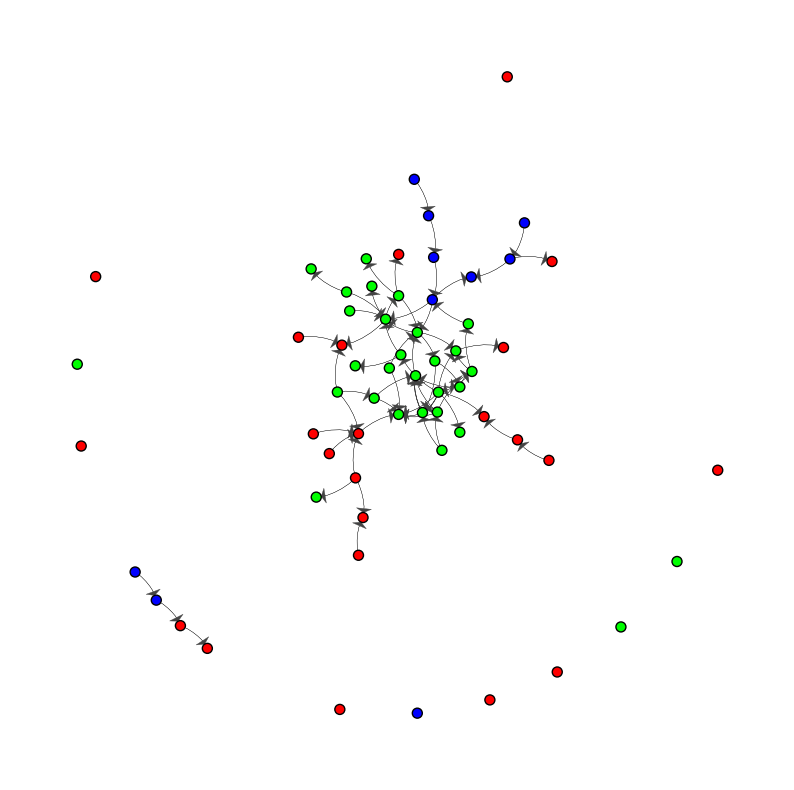

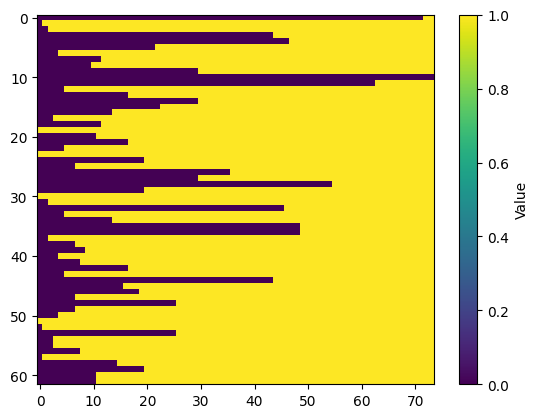

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:22<00:00, 89.72it/s, 3 steps of size 3.28e-01. acc. prob=0.84]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -4.99  / true alpha_social =  -5 ;  and estimated alpha_asocial =  -2.97 / true alpha_asocial =  -3.0
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -5  and alpha_asocial =  -2.5  with N =  110  and times =  99


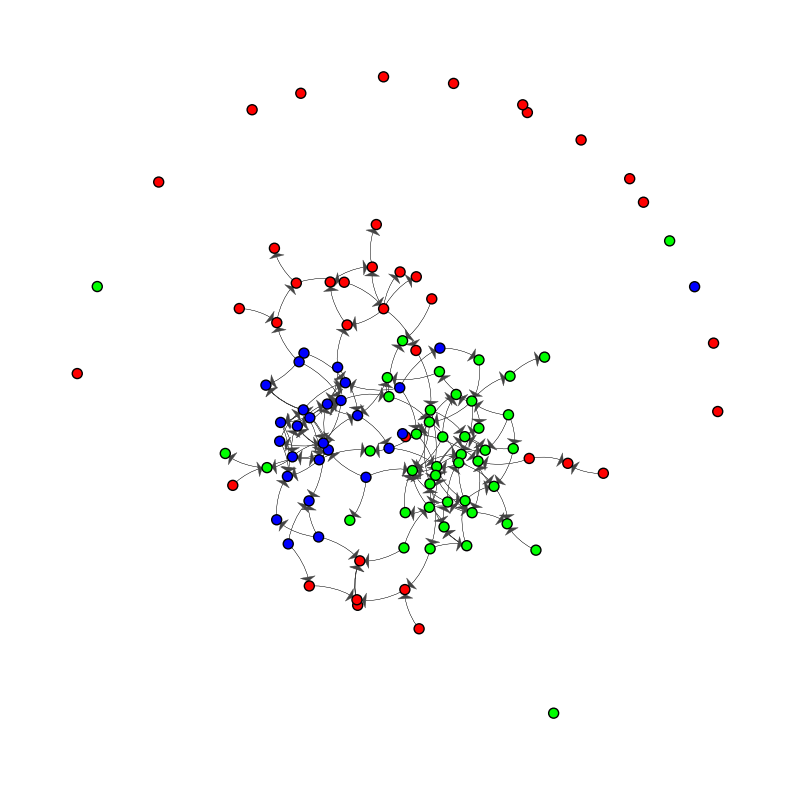

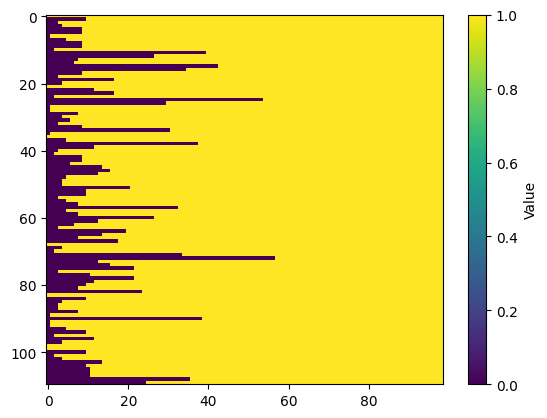

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:49<00:00, 40.72it/s, 7 steps of size 3.01e-01. acc. prob=0.80] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -3.85  / true alpha_social =  -5 ;  and estimated alpha_asocial =  -2.55 / true alpha_asocial =  -2.5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -5  and alpha_asocial =  -2.0  with N =  150  and times =  75


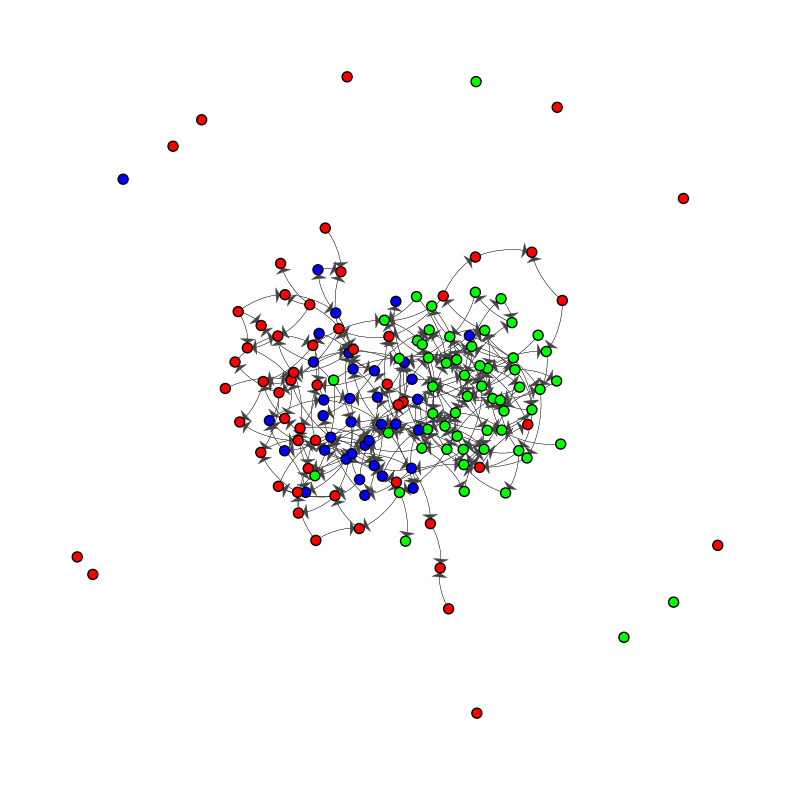

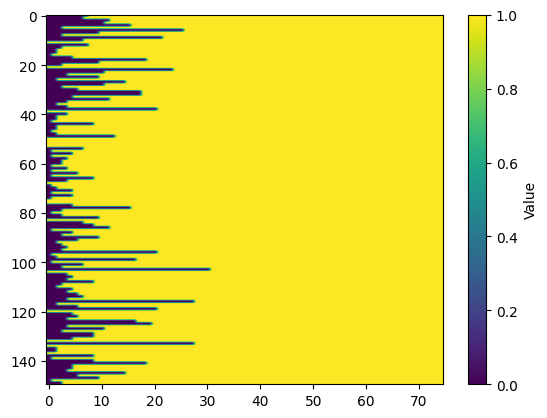

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:43<00:00, 46.14it/s, 3 steps of size 4.96e-01. acc. prob=0.75] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -6.56  / true alpha_social =  -5 ;  and estimated alpha_asocial =  -1.87 / true alpha_asocial =  -2.0
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -5  and alpha_asocial =  -1.5  with N =  150  and times =  69


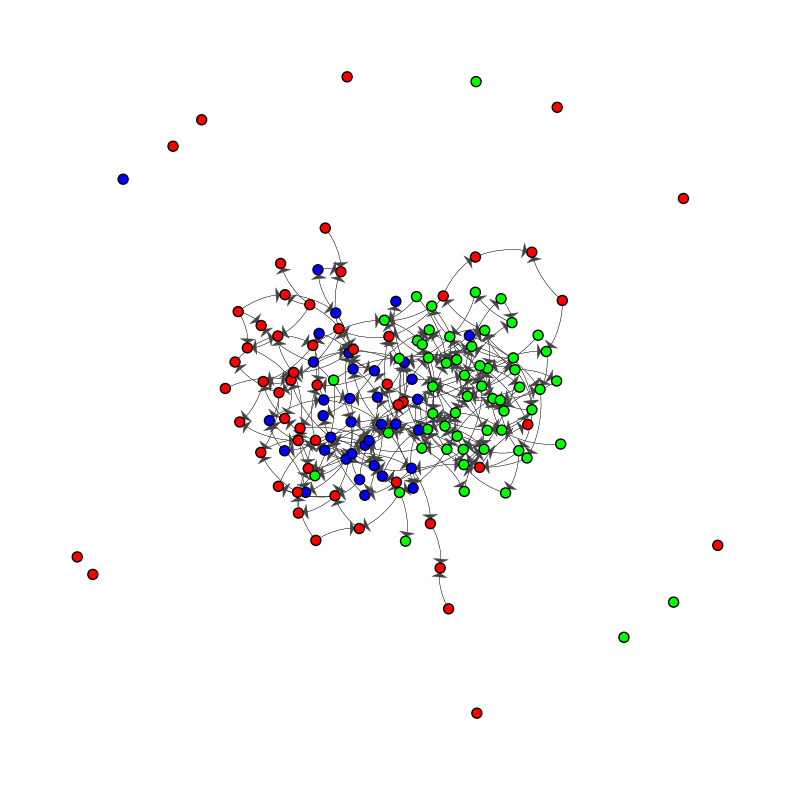

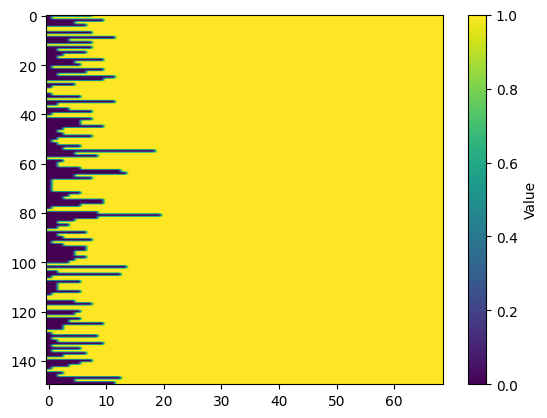

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:39<00:00, 50.70it/s, 7 steps of size 2.62e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -3.01  / true alpha_social =  -5 ;  and estimated alpha_asocial =  -1.67 / true alpha_asocial =  -1.5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -5  and alpha_asocial =  -1.0  with N =  125  and times =  86


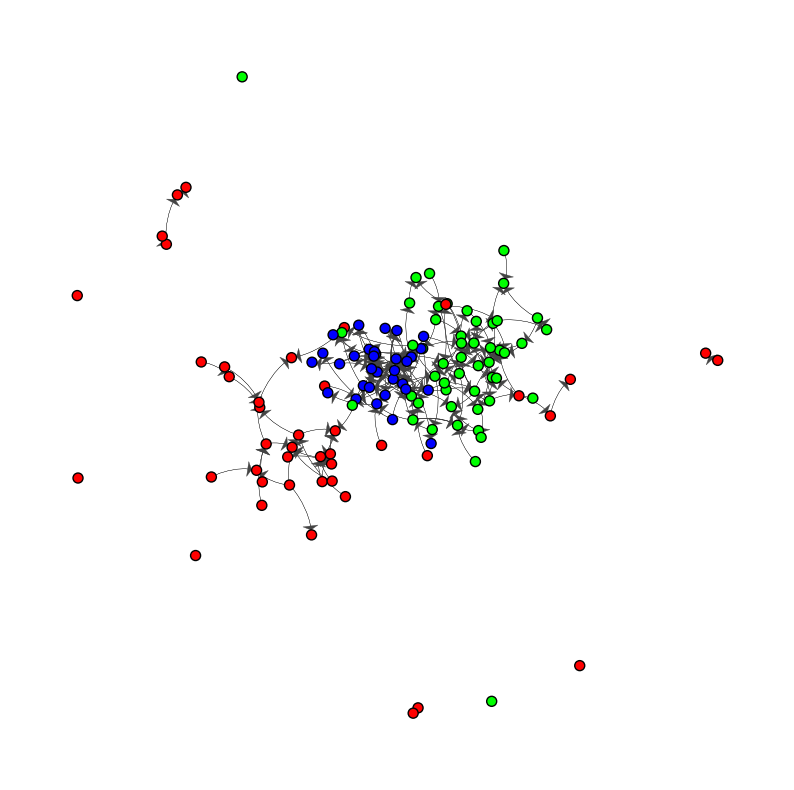

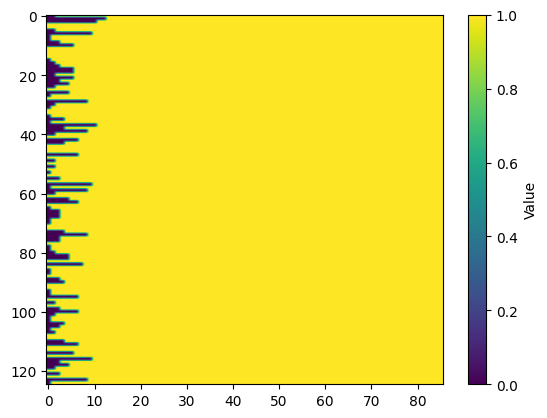

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:34<00:00, 58.68it/s, 3 steps of size 4.85e-01. acc. prob=0.75]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -5.39  / true alpha_social =  -5 ;  and estimated alpha_asocial =  -1.02 / true alpha_asocial =  -1.0
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -5  and alpha_asocial =  -0.5  with N =  58  and times =  66


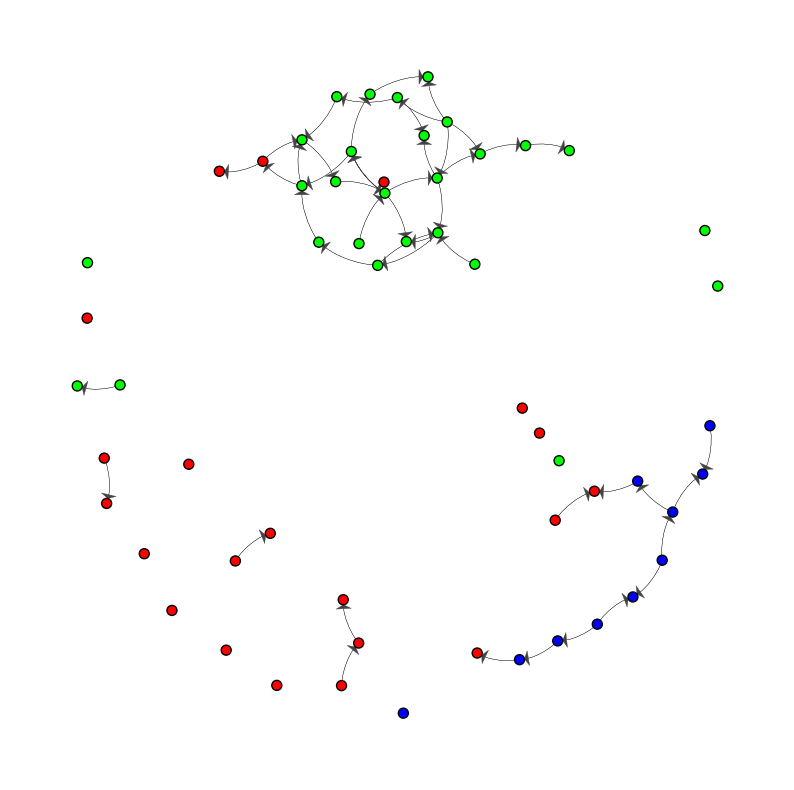

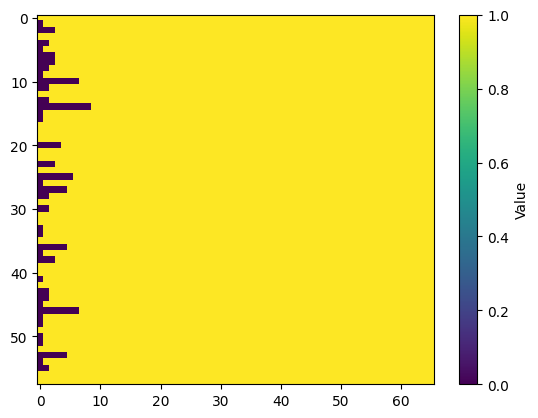

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:08<00:00, 244.11it/s, 3 steps of size 5.49e-01. acc. prob=0.89]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -5.13  / true alpha_social =  -5 ;  and estimated alpha_asocial =  -0.53 / true alpha_asocial =  -0.5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -5  and alpha_asocial =  0.0  with N =  96  and times =  98


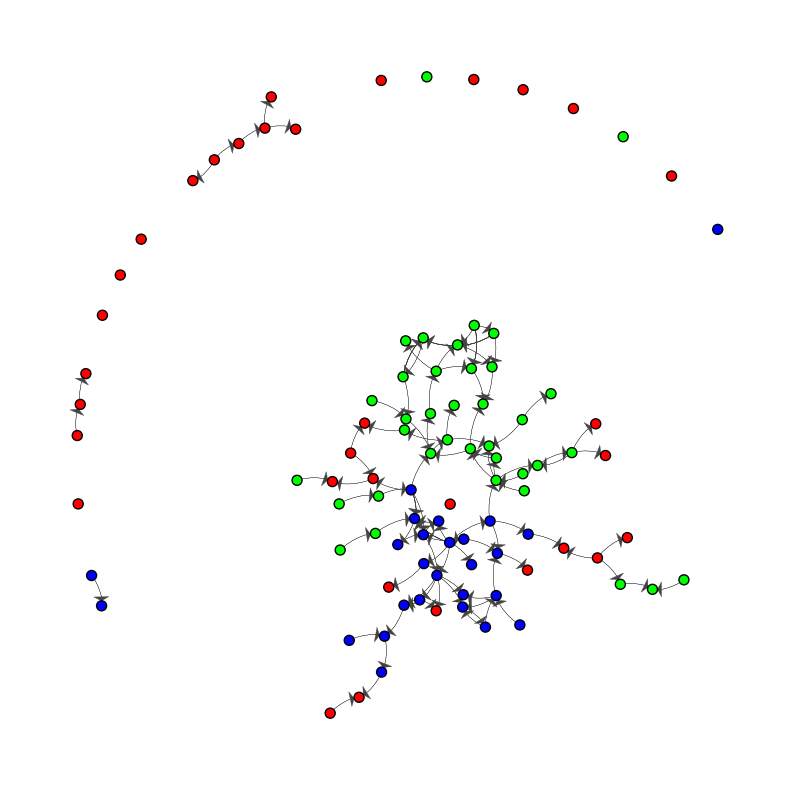

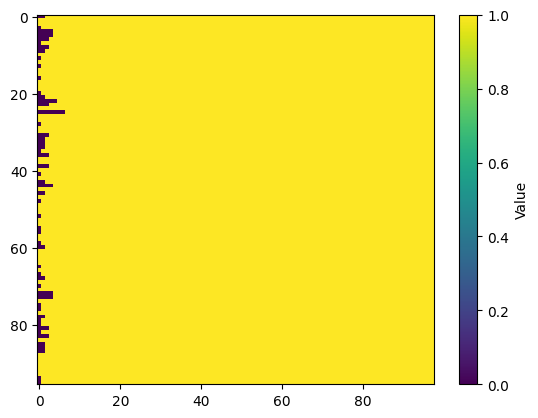

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:15<00:00, 129.02it/s, 3 steps of size 4.93e-01. acc. prob=0.90]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -5.33  / true alpha_social =  -5 ;  and estimated alpha_asocial =  -0.12 / true alpha_asocial =  0.0
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -5  and alpha_asocial =  0.5  with N =  77  and times =  73


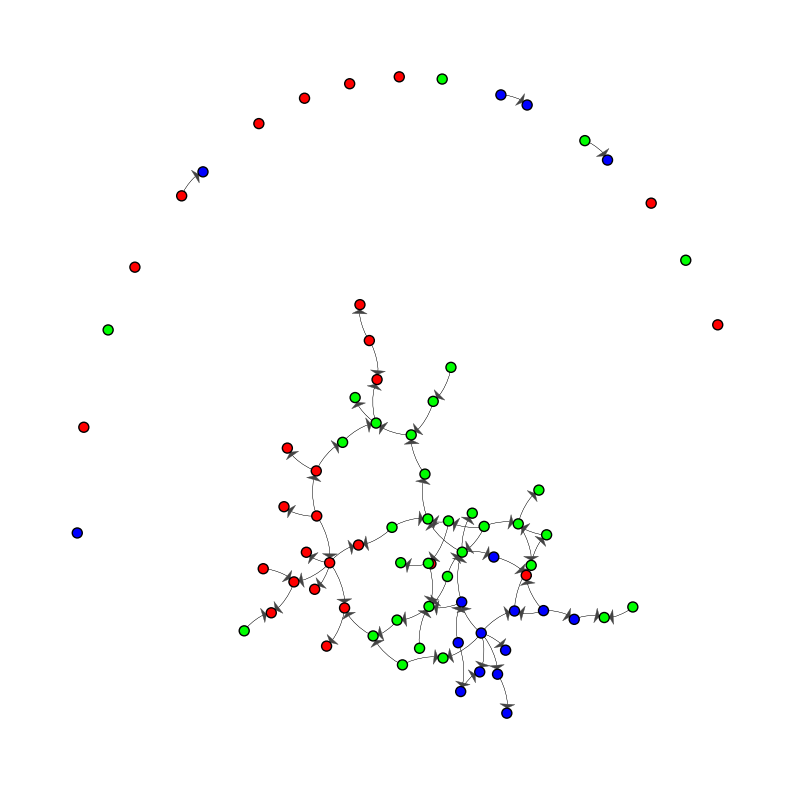

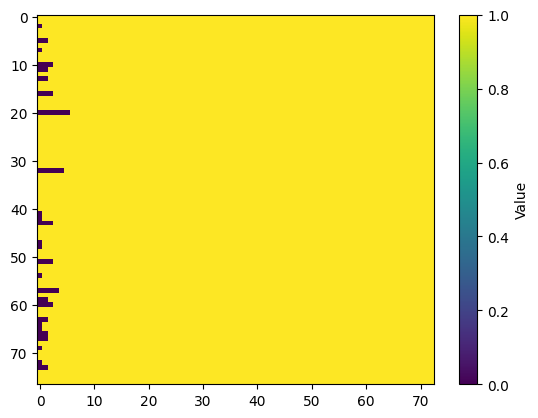

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:10<00:00, 191.71it/s, 3 steps of size 6.13e-01. acc. prob=0.88]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -5.36  / true alpha_social =  -5 ;  and estimated alpha_asocial =  0.3 / true alpha_asocial =  0.5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -5  and alpha_asocial =  1.0  with N =  131  and times =  63


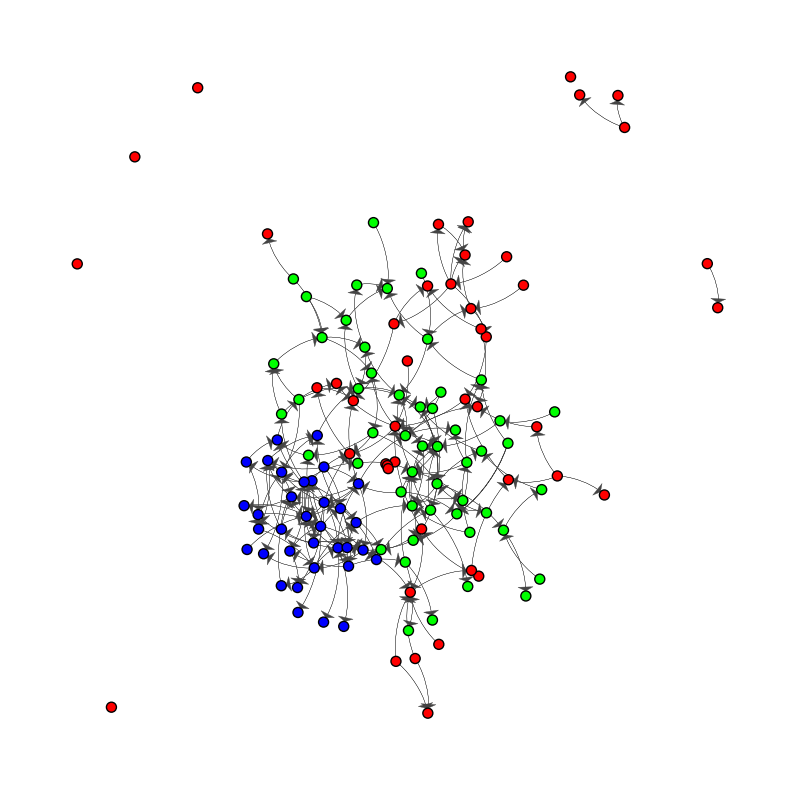

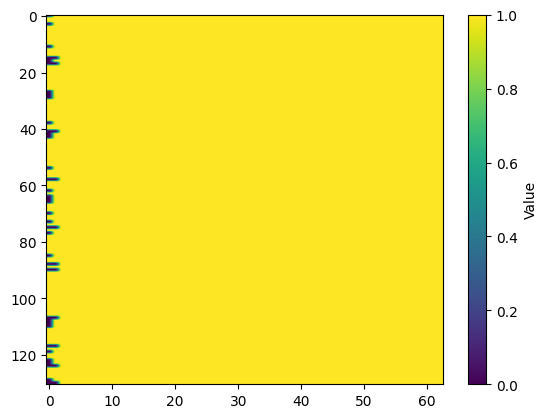

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:16<00:00, 119.67it/s, 3 steps of size 4.30e-01. acc. prob=0.89] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.39  / true alpha_social =  -5 ;  and estimated alpha_asocial =  0.97 / true alpha_asocial =  1.0
-------------------------------------------------------------


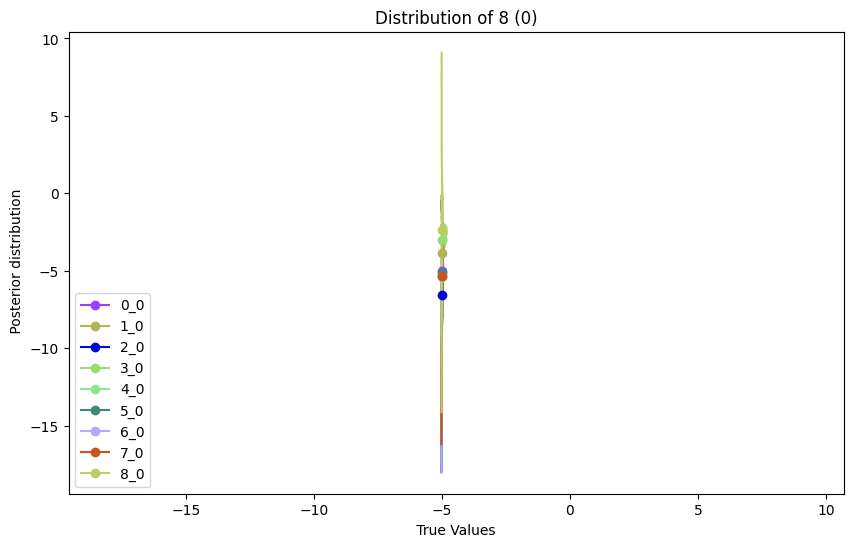

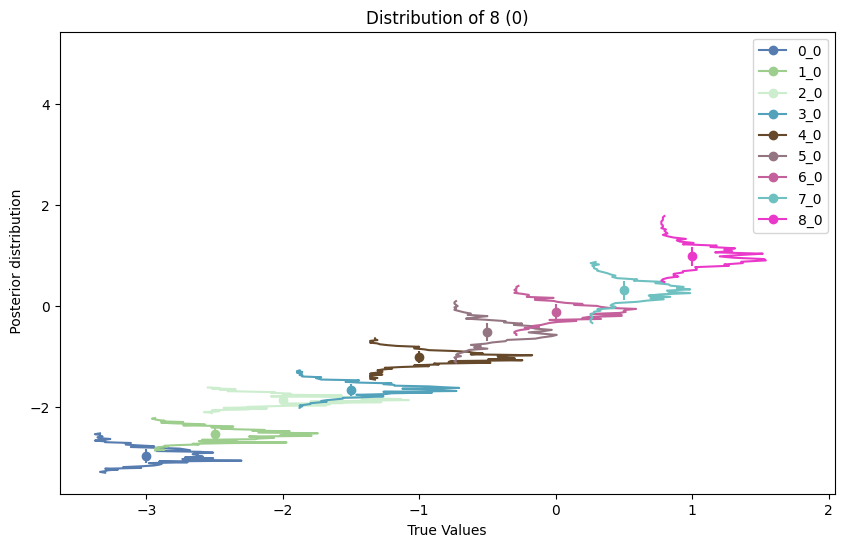

In [15]:
# ! When asocial effect is to big every individual learn at time step 0 and there is no acquision through time
sim1 = sim_estimations(alphas_asocial = jnp.arange(start=-3, stop=1.5, step=0.5),
                       alphas_social = jnp.repeat(-5, jnp.arange(start=-3, stop=1.5, step=0.5).shape[0]))

## No covariates, fixed null asocial effect and varying social effects

jax.local_device_count 32
Estimation for alpha_social =  -3.0  and alpha_asocial =  -5  with N =  121  and times =  91


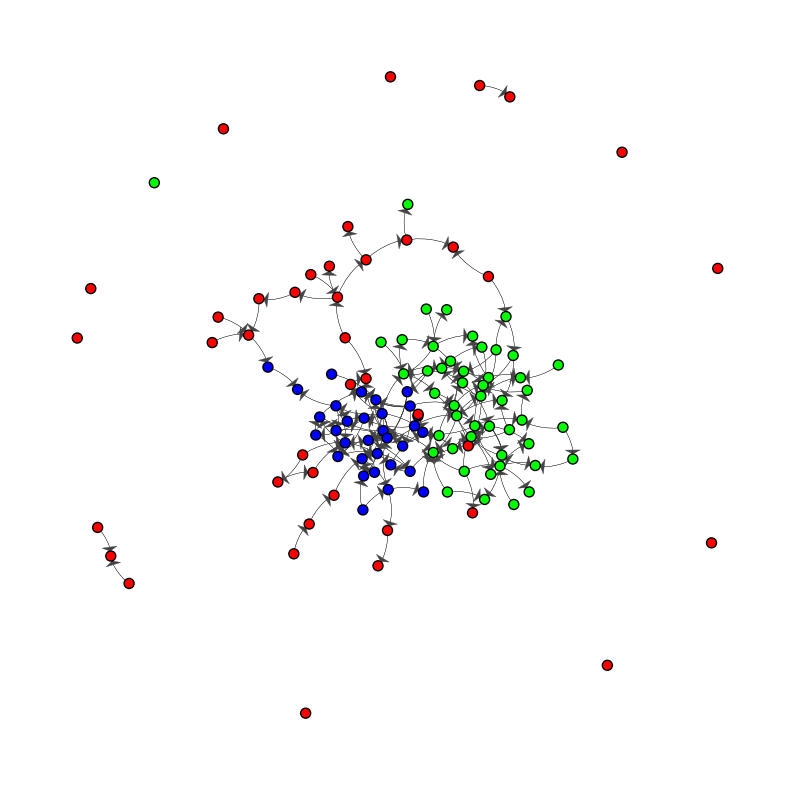

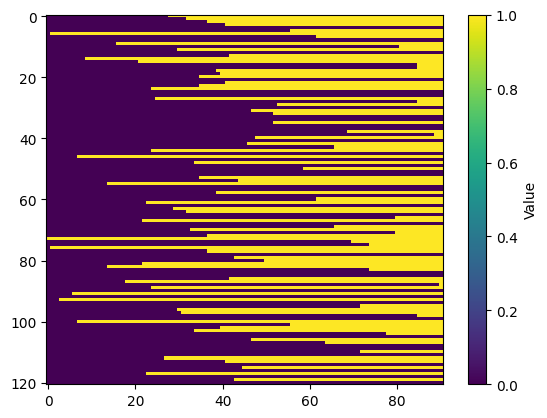

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:28<00:00, 70.04it/s, 3 steps of size 7.91e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.88  / true alpha_social =  -3.0 ;  and estimated alpha_asocial =  -5.21 / true alpha_asocial =  -5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -2.5  and alpha_asocial =  -5  with N =  156  and times =  59


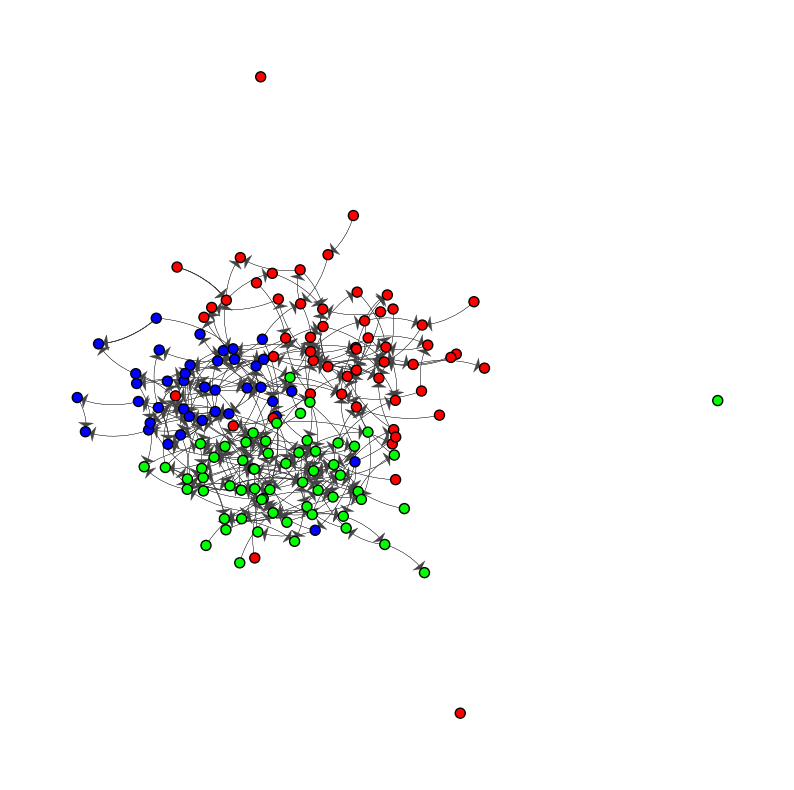

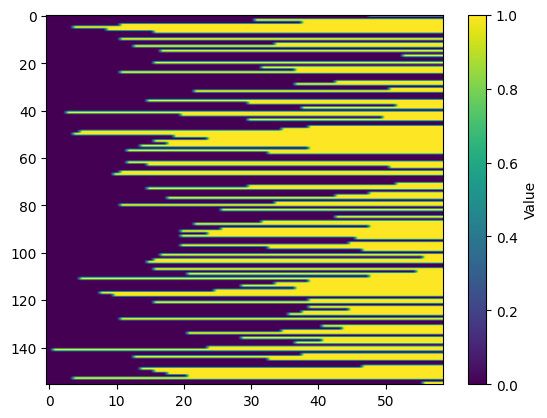

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:28<00:00, 70.89it/s, 7 steps of size 6.82e-01. acc. prob=0.94] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.19  / true alpha_social =  -2.5 ;  and estimated alpha_asocial =  -5.0 / true alpha_asocial =  -5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -2.0  and alpha_asocial =  -5  with N =  101  and times =  96


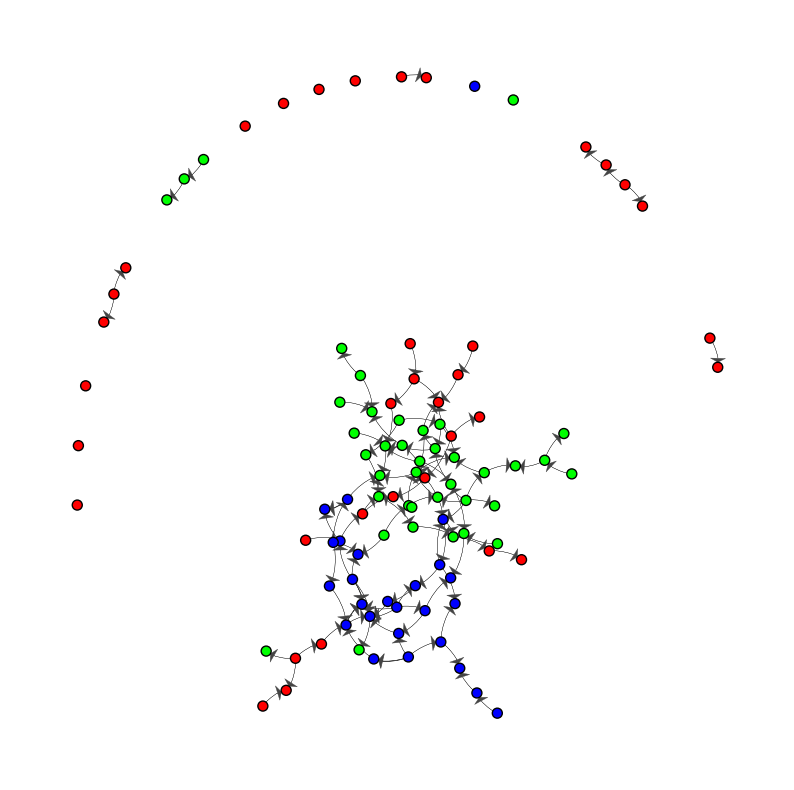

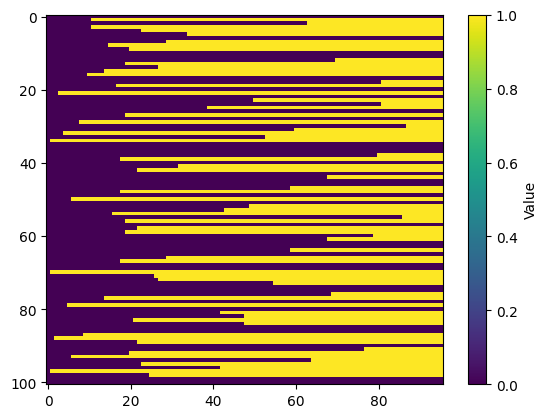

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:30<00:00, 65.09it/s, 3 steps of size 8.09e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.25  / true alpha_social =  -2.0 ;  and estimated alpha_asocial =  -4.92 / true alpha_asocial =  -5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -1.5  and alpha_asocial =  -5  with N =  136  and times =  78


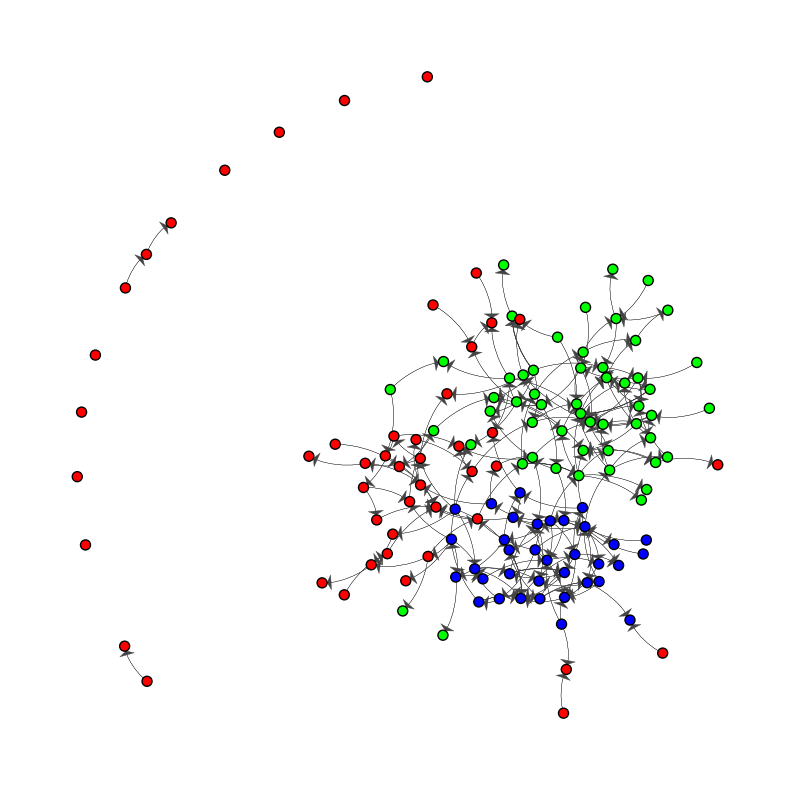

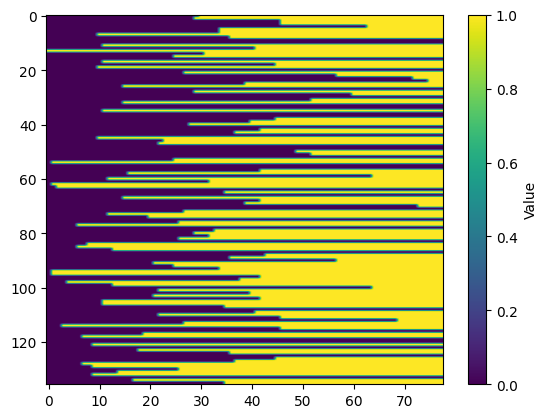

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:32<00:00, 61.69it/s, 3 steps of size 8.45e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -1.21  / true alpha_social =  -1.5 ;  and estimated alpha_asocial =  -4.96 / true alpha_asocial =  -5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -1.0  and alpha_asocial =  -5  with N =  141  and times =  96


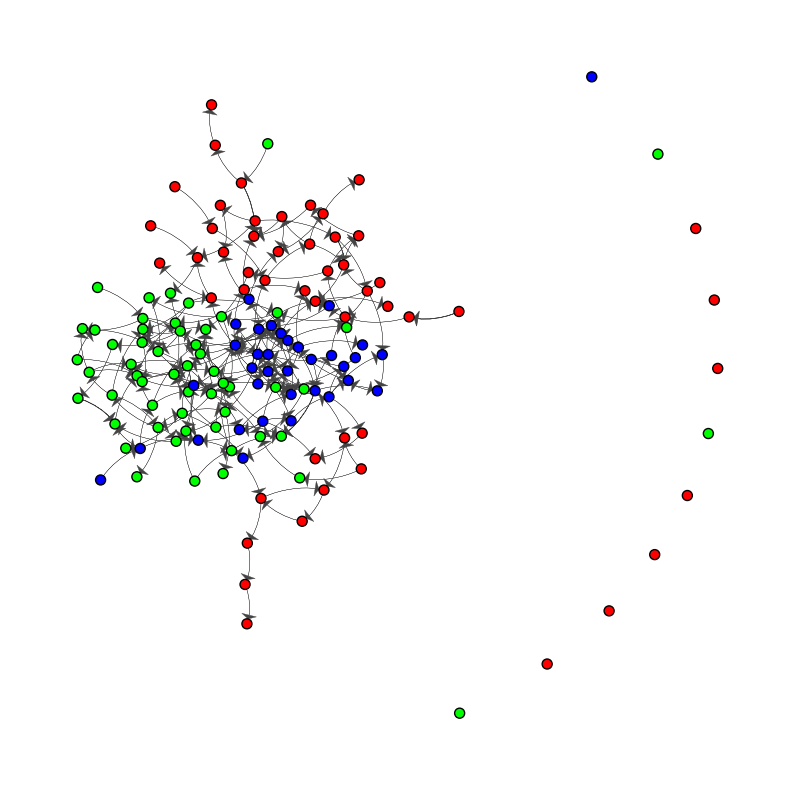

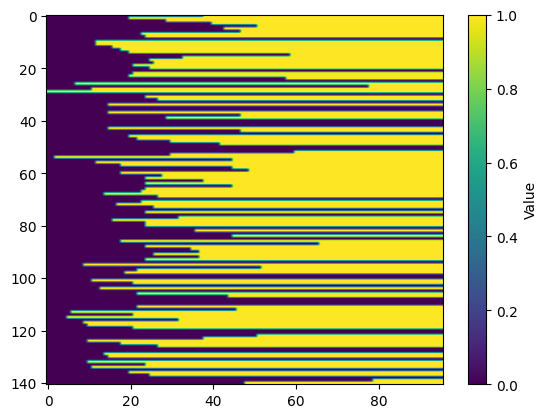

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:40<00:00, 48.98it/s, 3 steps of size 8.73e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.97  / true alpha_social =  -1.0 ;  and estimated alpha_asocial =  -5.35 / true alpha_asocial =  -5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.5  and alpha_asocial =  -5  with N =  165  and times =  91


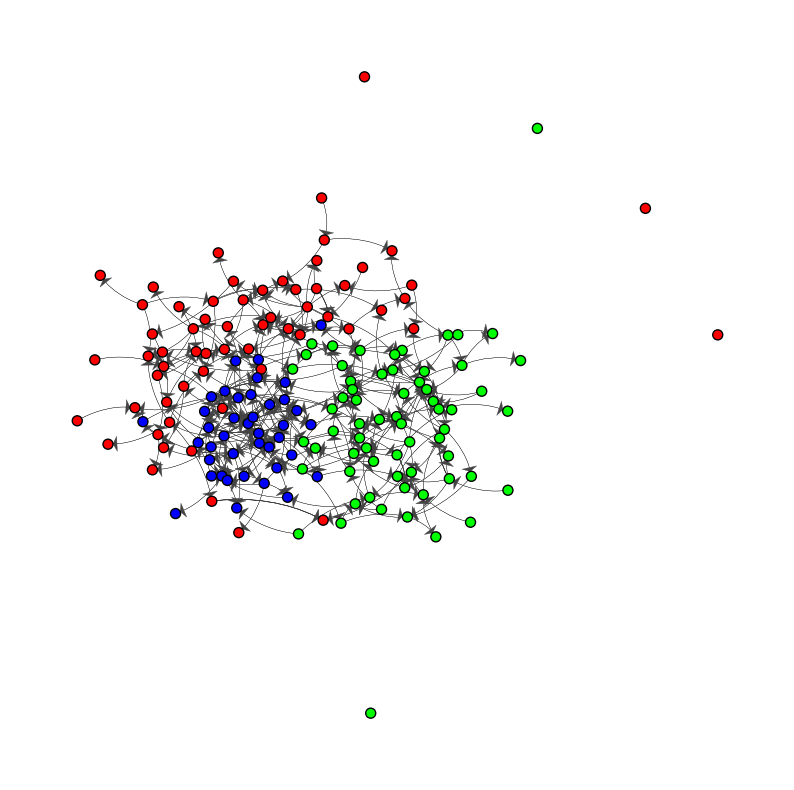

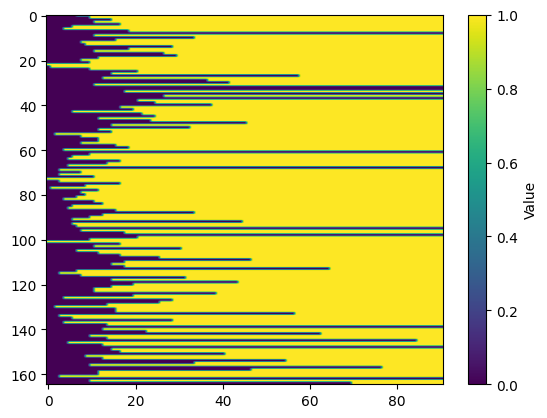

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:52<00:00, 38.31it/s, 3 steps of size 8.58e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.64  / true alpha_social =  -0.5 ;  and estimated alpha_asocial =  -4.52 / true alpha_asocial =  -5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.0  and alpha_asocial =  -5  with N =  108  and times =  65


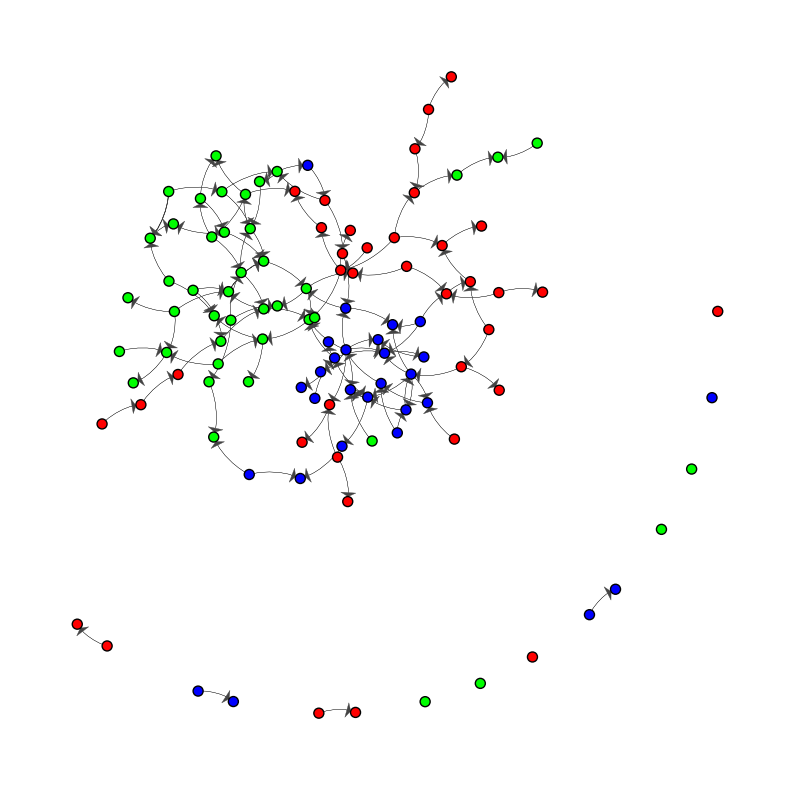

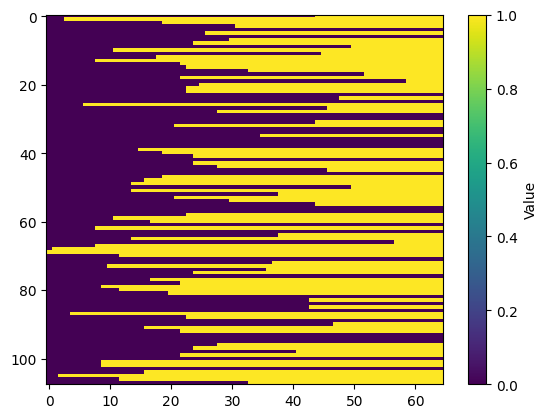

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:19<00:00, 100.16it/s, 3 steps of size 1.02e+00. acc. prob=0.86]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.19  / true alpha_social =  0.0 ;  and estimated alpha_asocial =  -5.31 / true alpha_asocial =  -5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.5  and alpha_asocial =  -5  with N =  60  and times =  73


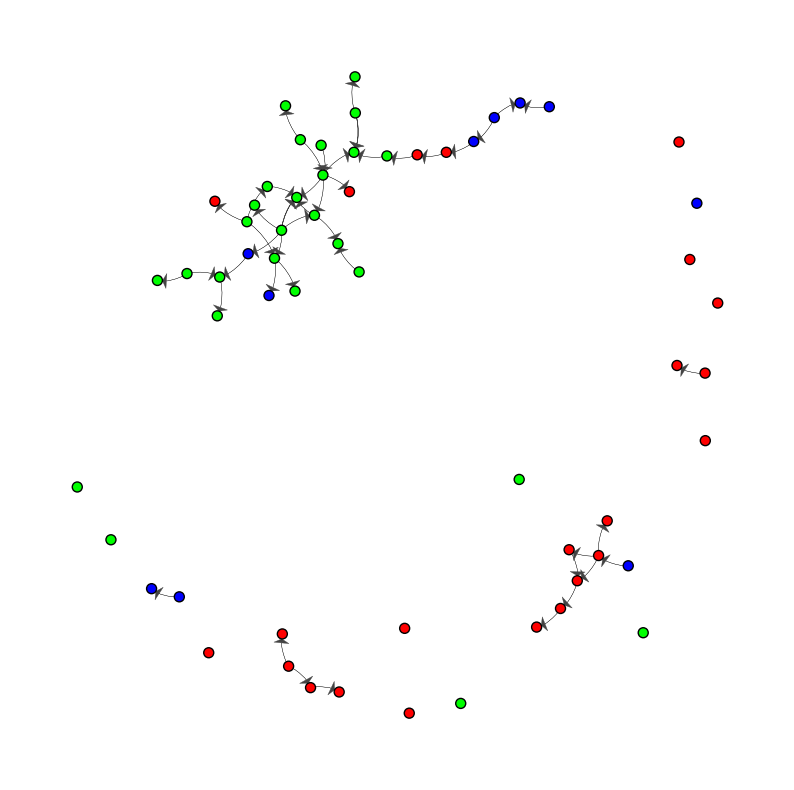

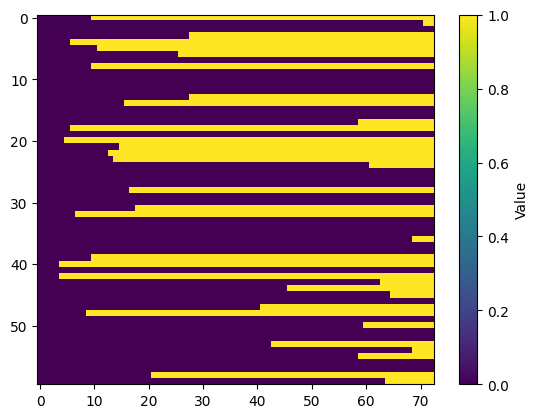

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:11<00:00, 172.55it/s, 3 steps of size 8.06e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.21  / true alpha_social =  0.5 ;  and estimated alpha_asocial =  -5.43 / true alpha_asocial =  -5
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  1.0  and alpha_asocial =  -5  with N =  73  and times =  80


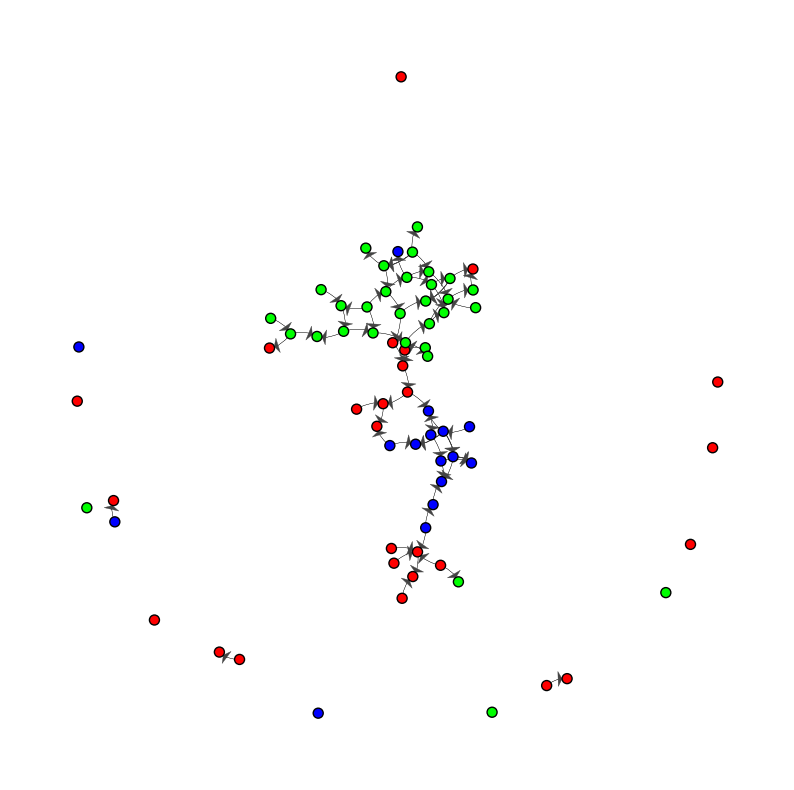

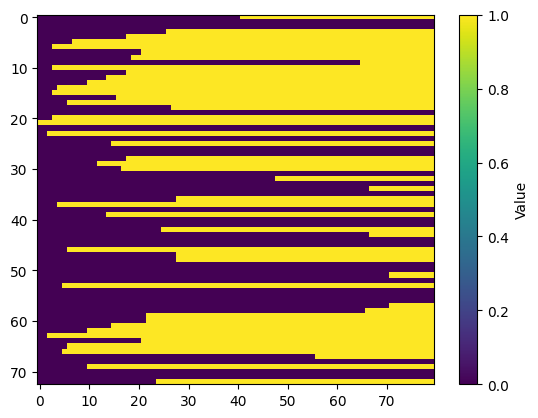

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:18<00:00, 107.68it/s, 3 steps of size 7.67e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.63  / true alpha_social =  1.0 ;  and estimated alpha_asocial =  -5.21 / true alpha_asocial =  -5
-------------------------------------------------------------


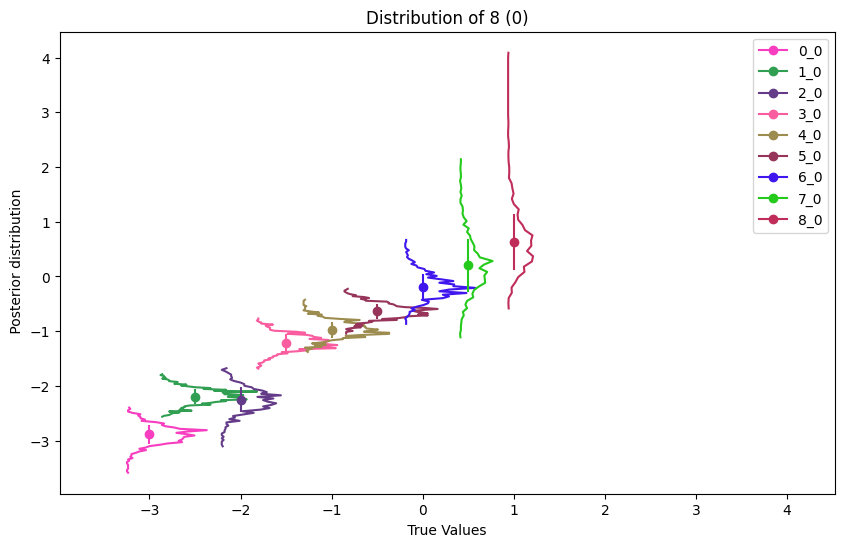

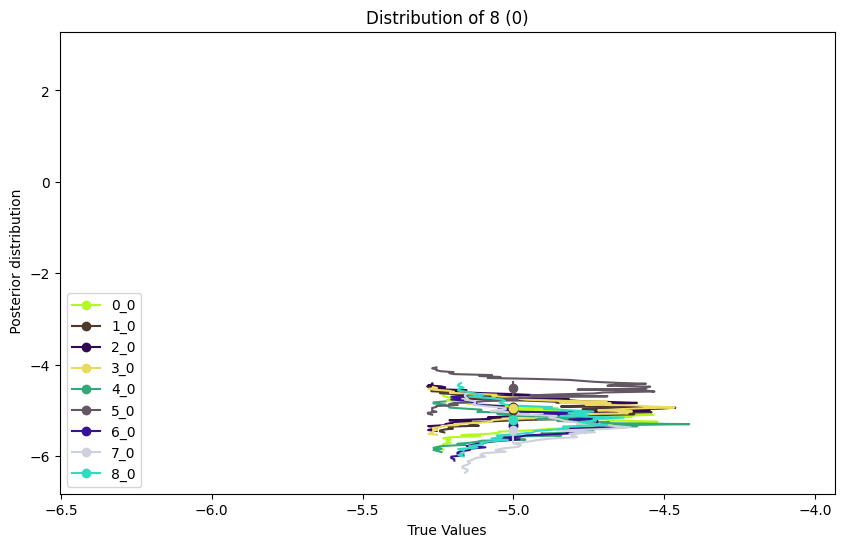

In [ ]:
import time
sim2 = sim_estimations(alphas_asocial = jnp.repeat(-5, jnp.arange(start=-3, stop=1.5, step=0.5).shape[0]),
                       alphas_social = jnp.arange(start=-3, stop=1.5, step=0.5))

## No covariates, varying asocial and varying social effects

jax.local_device_count 32
Estimation for alpha_social =  -0.7292769944090071  and alpha_asocial =  0.8837442102887392  with N =  121  and times =  91


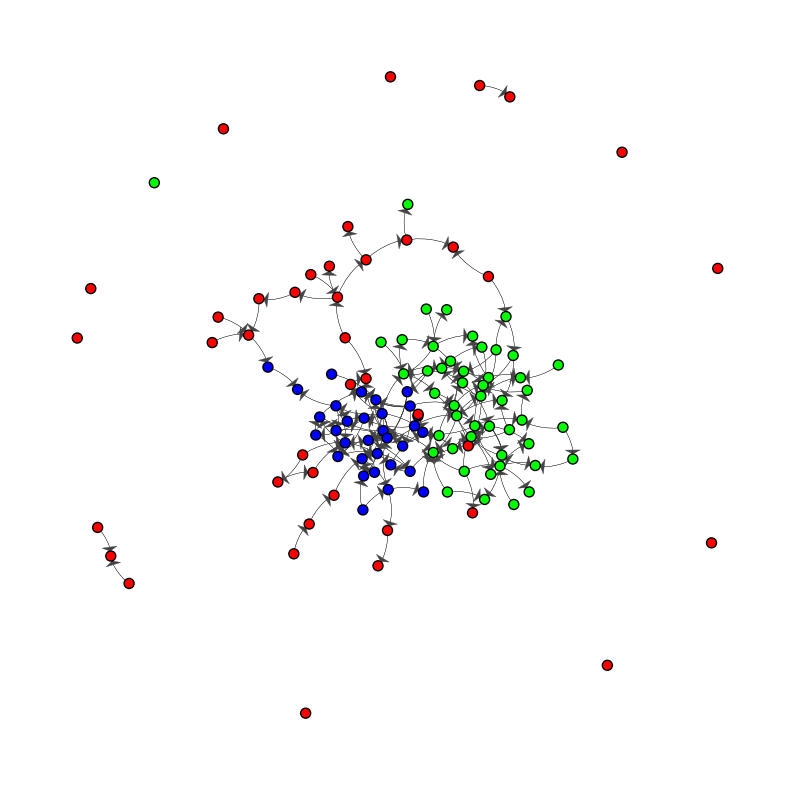

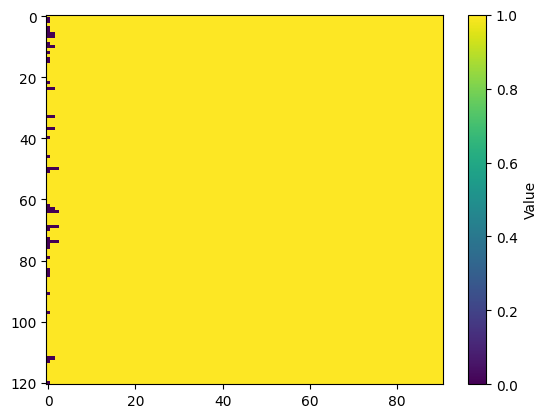

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:14<00:00, 134.67it/s, 3 steps of size 5.91e-01. acc. prob=0.80] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.31  / true alpha_social =  -0.7292769944090071 ;  and estimated alpha_asocial =  0.78 / true alpha_asocial =  0.8837442102887392
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  1.1935965663866743  and alpha_asocial =  -0.23867708137886678  with N =  156  and times =  59


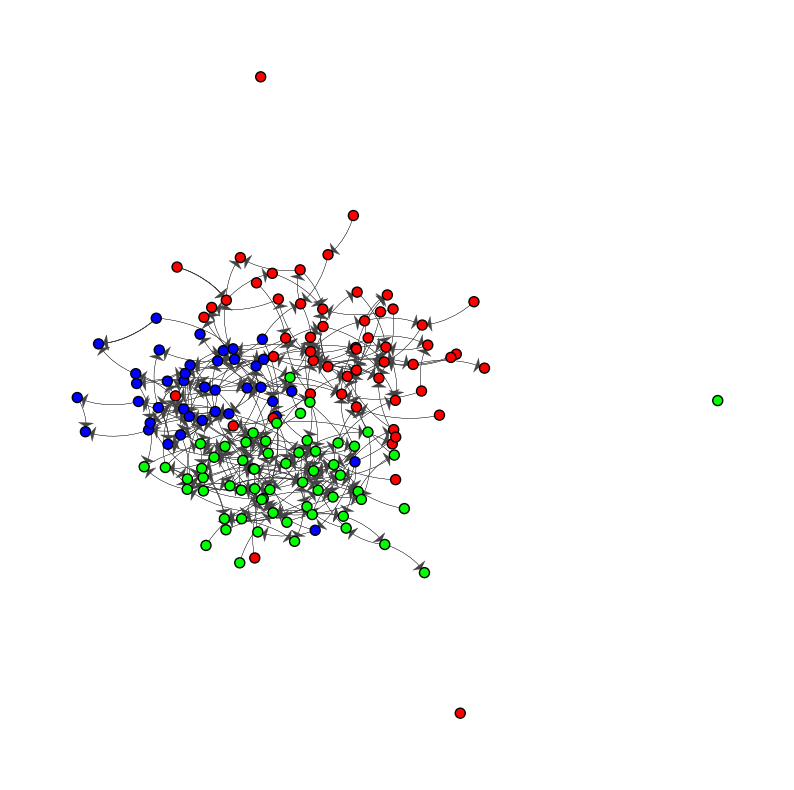

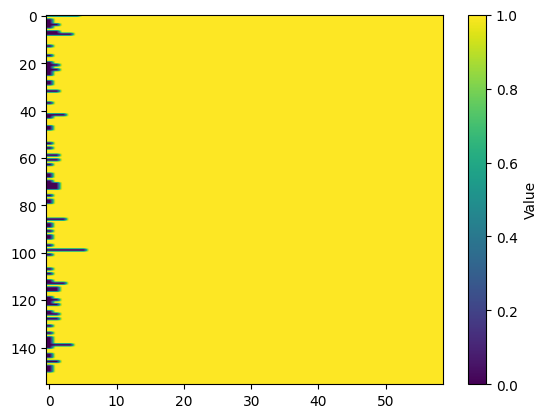

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:18<00:00, 106.51it/s, 3 steps of size 6.96e-01. acc. prob=0.80] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  5.25  / true alpha_social =  1.1935965663866743 ;  and estimated alpha_asocial =  0.06 / true alpha_asocial =  -0.23867708137886678
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -2.0651493725704664  and alpha_asocial =  -1.04734646404846  with N =  101  and times =  96


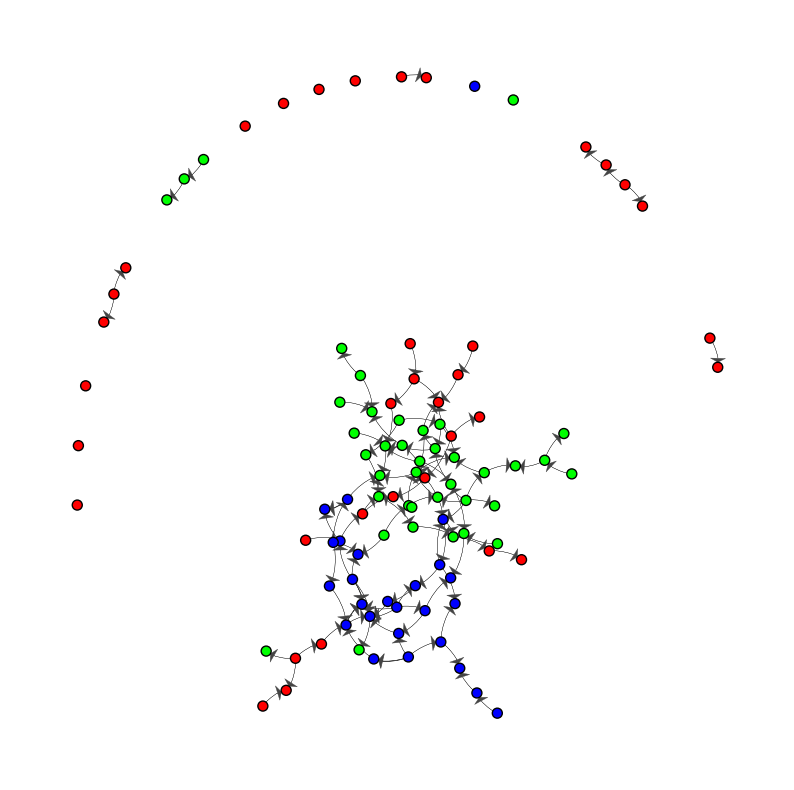

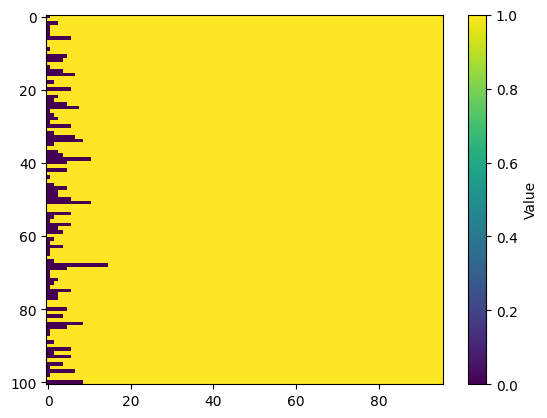

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:20<00:00, 95.64it/s, 3 steps of size 4.86e-01. acc. prob=0.79]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -4.89  / true alpha_social =  -2.0651493725704664 ;  and estimated alpha_asocial =  -1.07 / true alpha_asocial =  -1.04734646404846
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -2.912842693575497  and alpha_asocial =  -0.5697399190747177  with N =  136  and times =  78


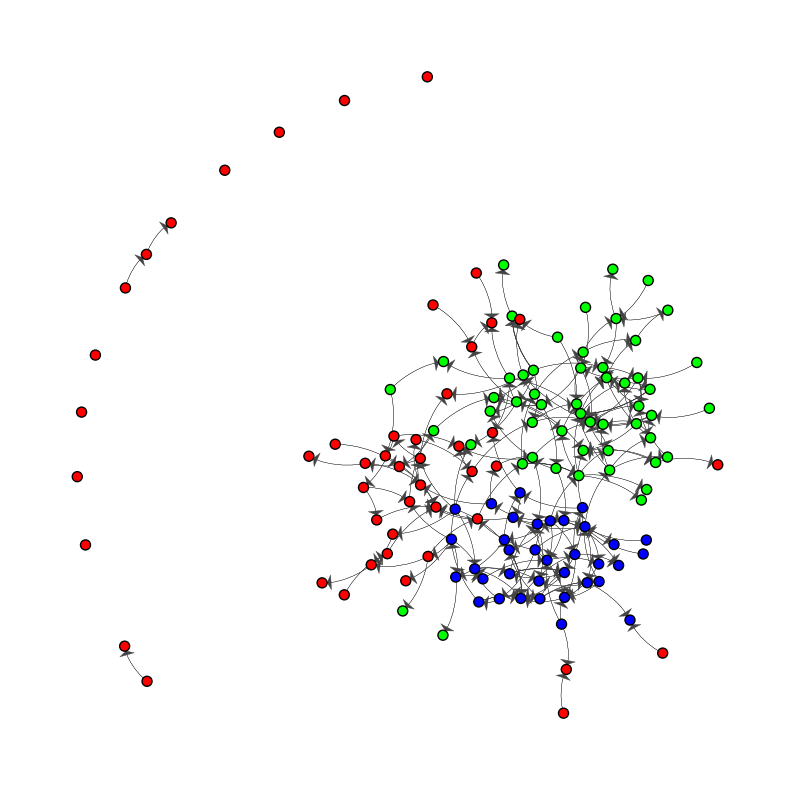

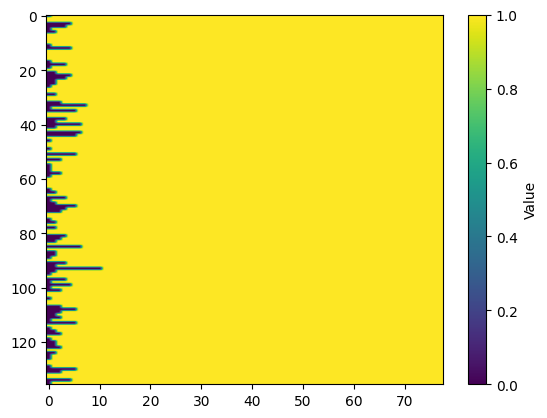

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:25<00:00, 77.23it/s, 7 steps of size 3.29e-01. acc. prob=0.85]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -4.97  / true alpha_social =  -2.912842693575497 ;  and estimated alpha_asocial =  -0.63 / true alpha_asocial =  -0.5697399190747177
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  1.137811957595625  and alpha_asocial =  0.702828519238424  with N =  141  and times =  96


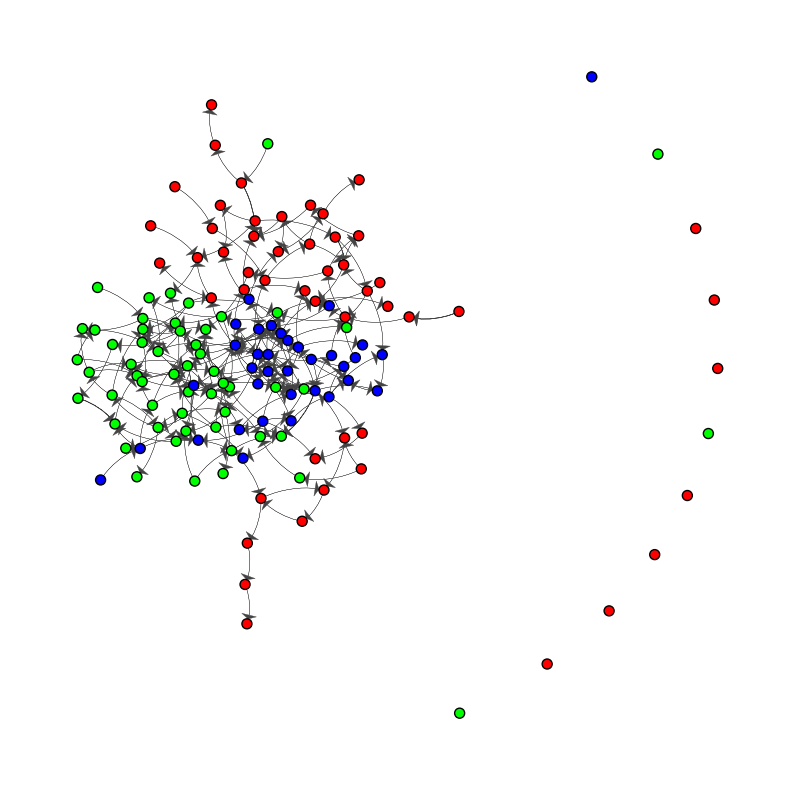

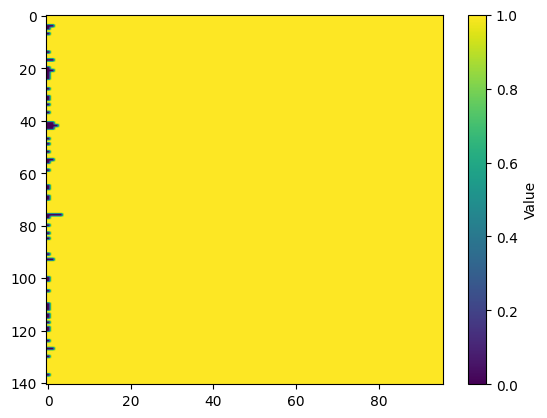

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:21<00:00, 92.50it/s, 3 steps of size 5.42e-01. acc. prob=0.90] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  4.76  / true alpha_social =  1.137811957595625 ;  and estimated alpha_asocial =  0.64 / true alpha_asocial =  0.702828519238424
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -1.3274514290750994  and alpha_asocial =  0.9056711589233836  with N =  165  and times =  91


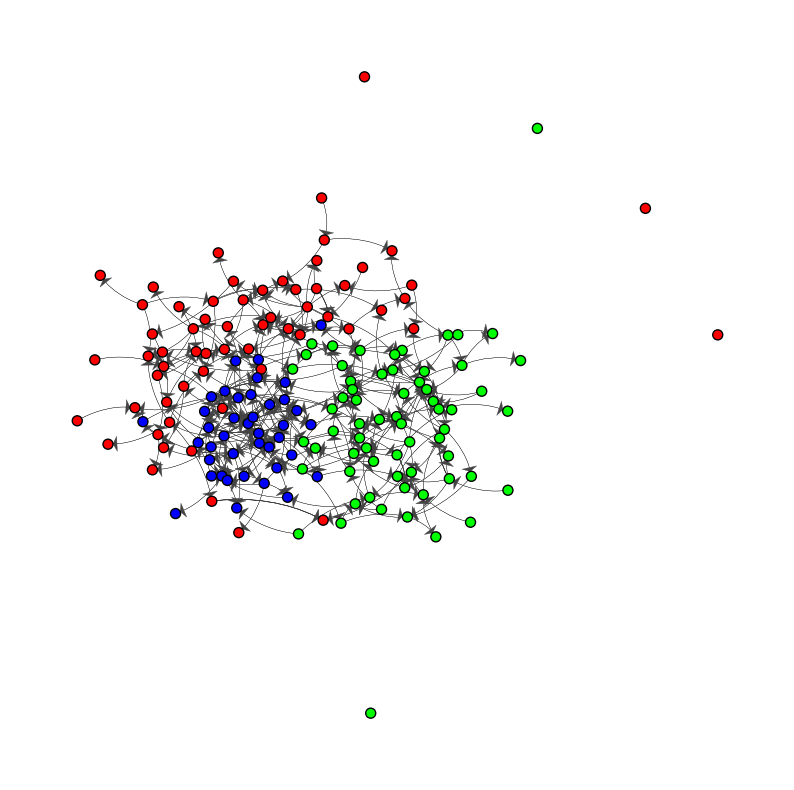

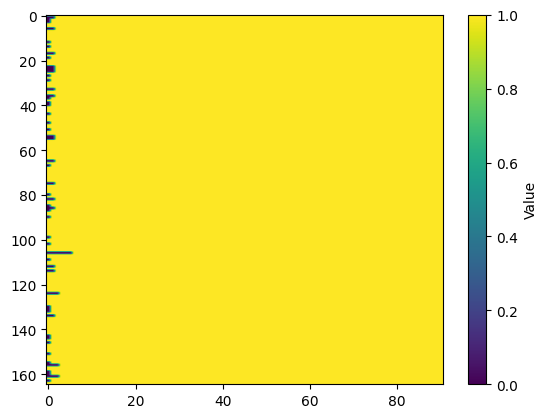

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:27<00:00, 73.76it/s, 3 steps of size 5.28e-01. acc. prob=0.77] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -4.67  / true alpha_social =  -1.3274514290750994 ;  and estimated alpha_asocial =  0.7 / true alpha_asocial =  0.9056711589233836
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -2.2212812020372983  and alpha_asocial =  1.1277266118963556  with N =  108  and times =  65


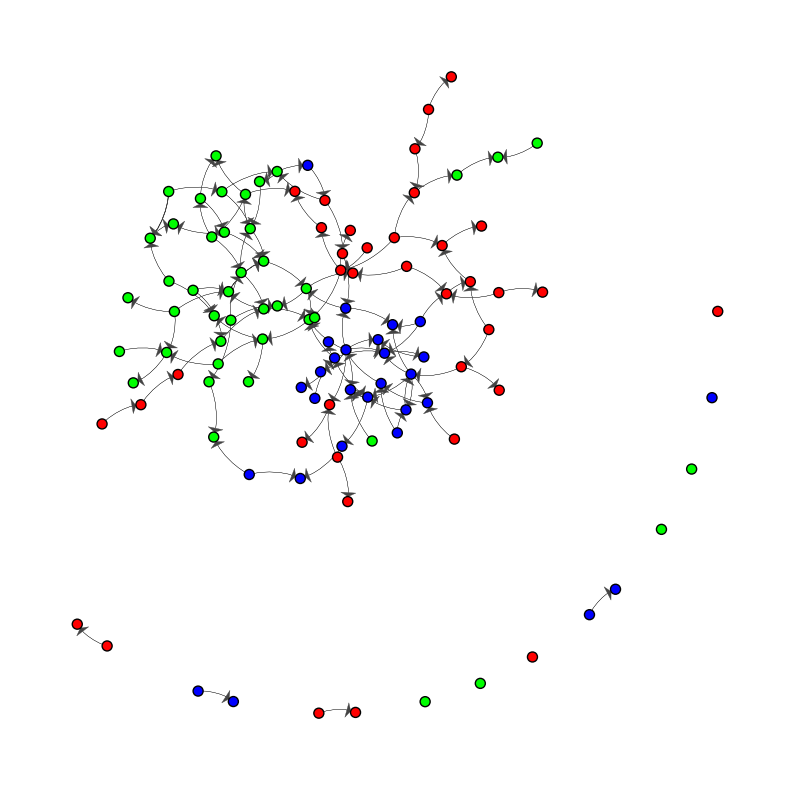

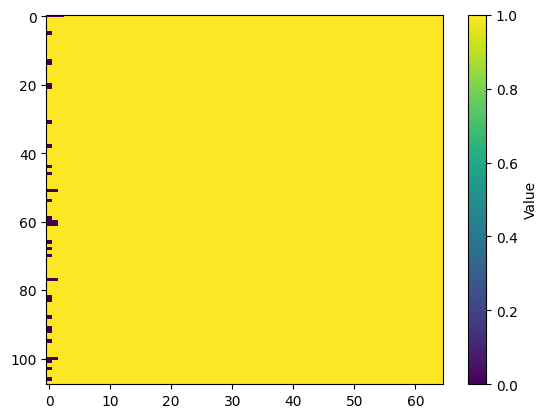

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:12<00:00, 161.47it/s, 3 steps of size 5.64e-01. acc. prob=0.86]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.29  / true alpha_social =  -2.2212812020372983 ;  and estimated alpha_asocial =  1.05 / true alpha_asocial =  1.1277266118963556
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.49827304454501964  and alpha_asocial =  -1.5118819112588975  with N =  60  and times =  73


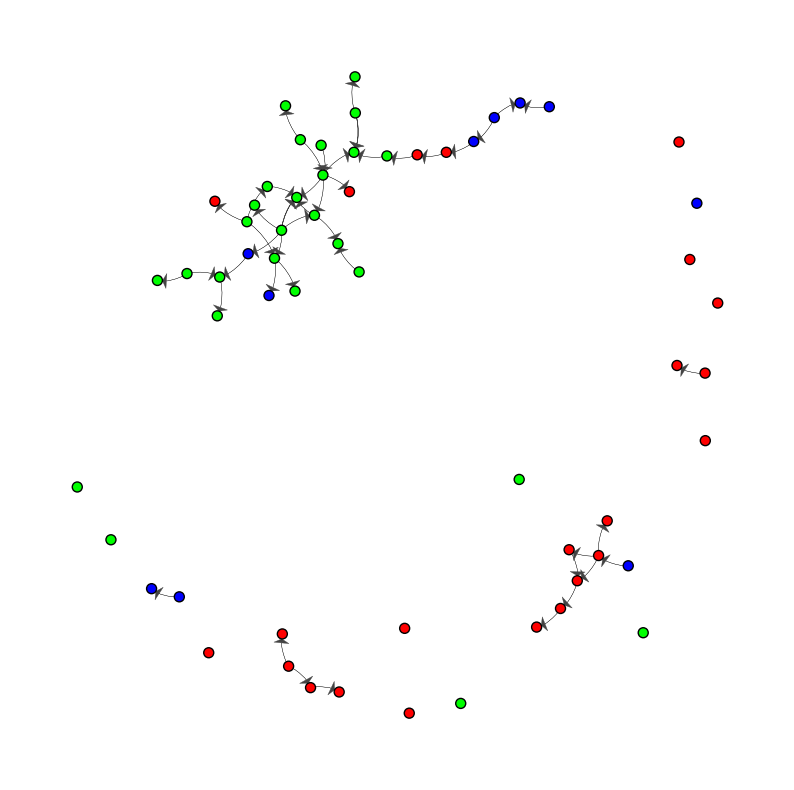

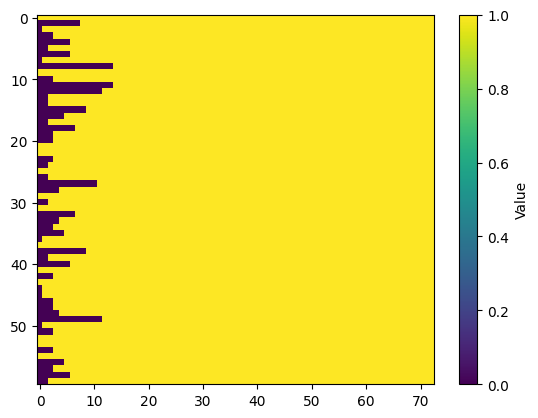

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:10<00:00, 193.44it/s, 3 steps of size 3.66e-01. acc. prob=0.93] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.61  / true alpha_social =  -0.49827304454501964 ;  and estimated alpha_asocial =  -1.51 / true alpha_asocial =  -1.5118819112588975
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -2.9714502112148184  and alpha_asocial =  -2.8880110195545305  with N =  73  and times =  80


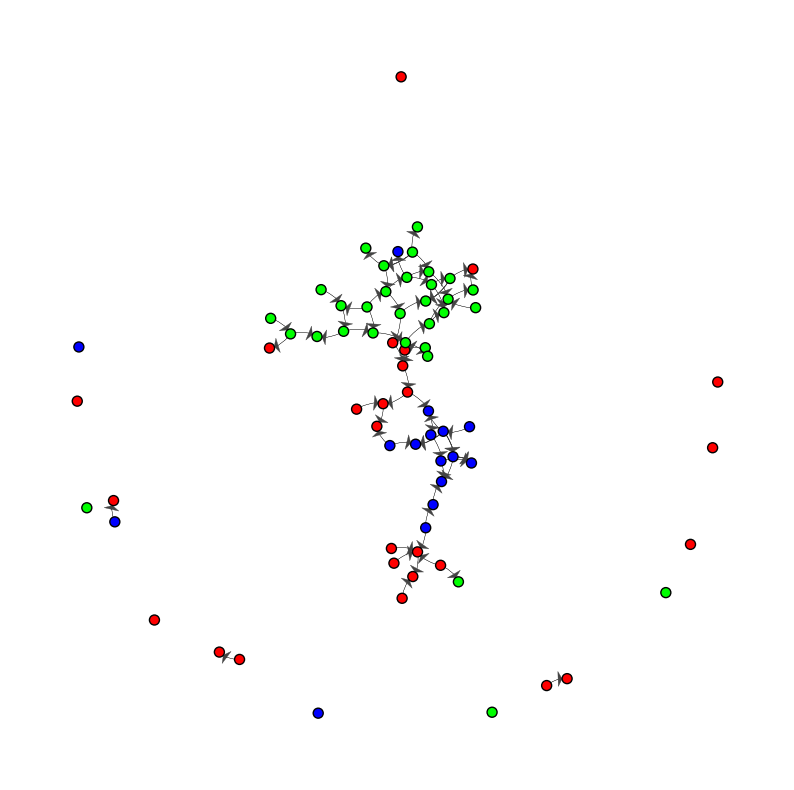

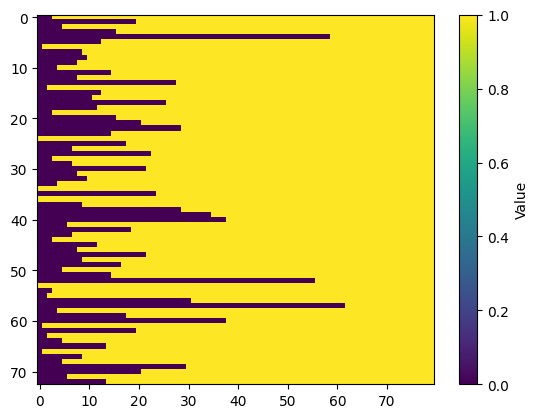

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:25<00:00, 79.94it/s, 7 steps of size 3.57e-01. acc. prob=0.65]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -4.5  / true alpha_social =  -2.9714502112148184 ;  and estimated alpha_asocial =  -2.74 / true alpha_asocial =  -2.8880110195545305
-------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.537215690693396  and alpha_asocial =  -1.7228550848689443  with N =  77  and times =  90


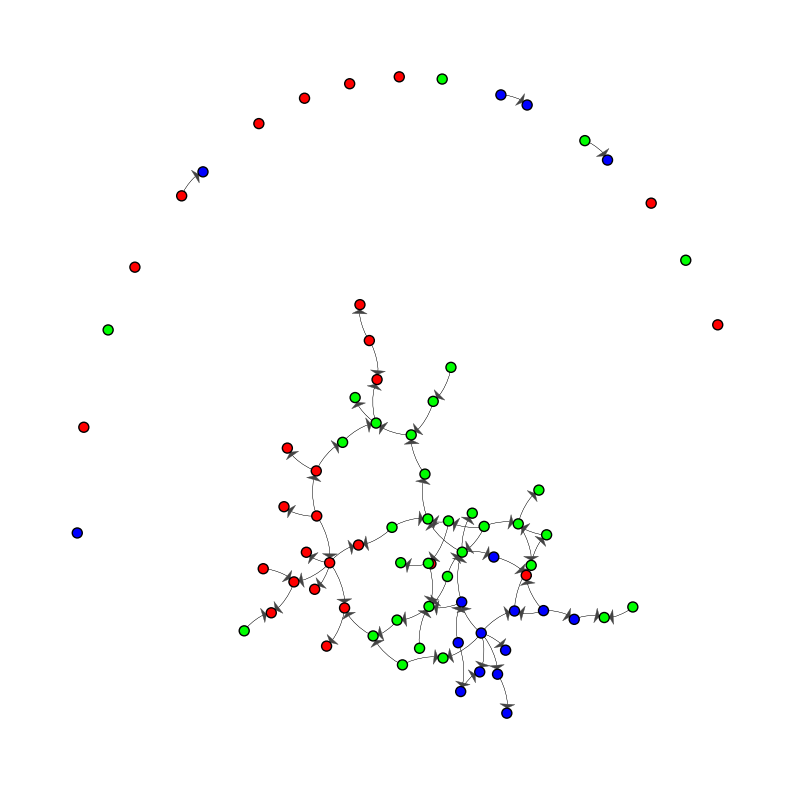

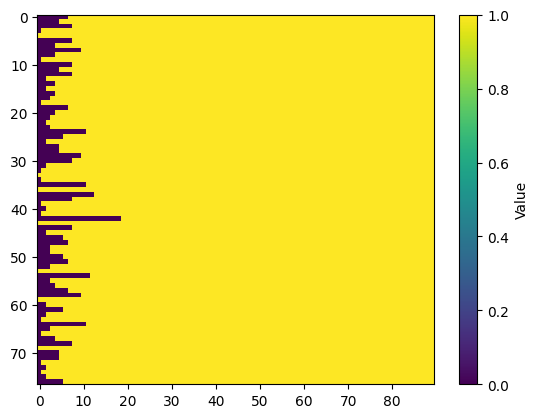

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:13<00:00, 149.16it/s, 7 steps of size 4.20e-01. acc. prob=0.93] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.27  / true alpha_social =  0.537215690693396 ;  and estimated alpha_asocial =  -1.81 / true alpha_asocial =  -1.7228550848689443
-------------------------------------------------------------


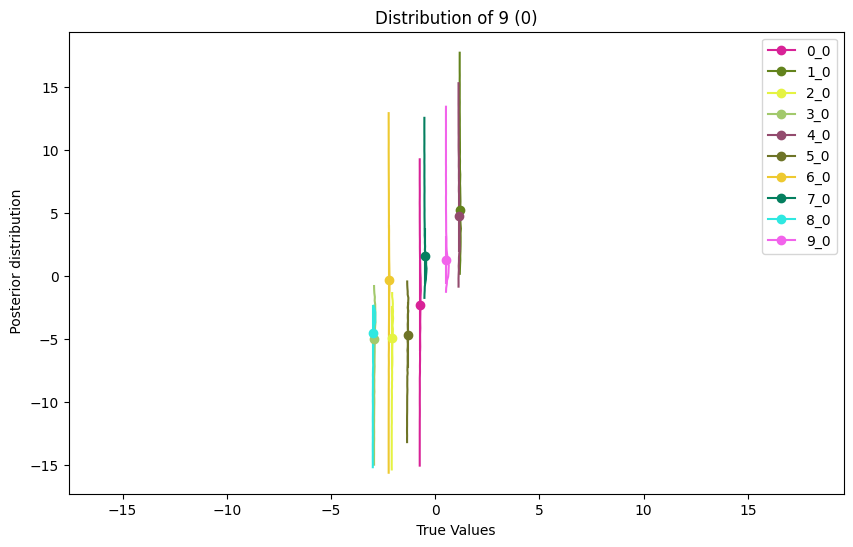

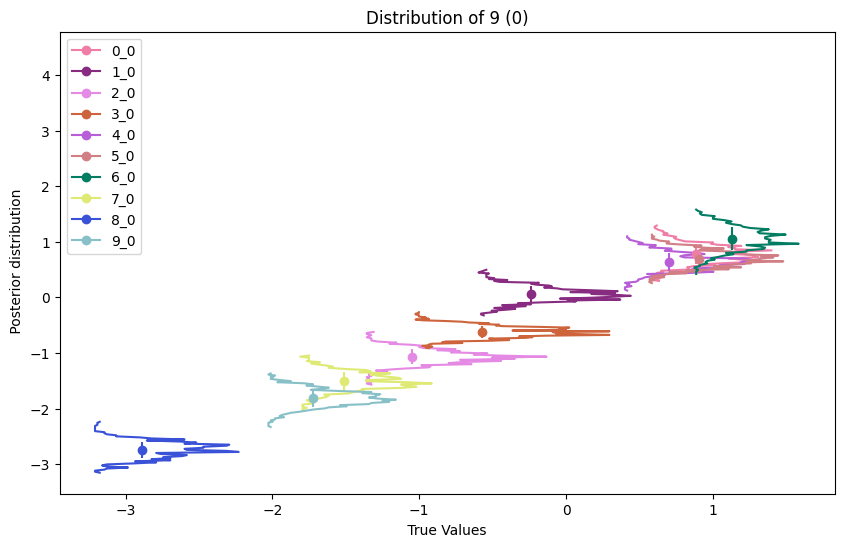

In [ ]:
import time
sim3 = sim_estimations(alphas_asocial =  m.dist.uniform(-3, 1.5, shape=(Nsim,), sample = True, seed=int(time.time())),
                       alphas_social = m.dist.uniform(-3, 1.5, shape=(Nsim,), sample = True, seed=int(time.time()+1)))
#! both asocial and soical effect reach 4, then diffusion process happens very fast
#! We will make variaton in small range, for social range between 0.1 to 0.8 and for asocial range between 0.1 to 0.5

## With covariates
Due to issues related to long tail posterior distribution for social rate when true social transmission rate is strong, we will fix social and asocial rates to a value that is not too strong but still present and incorporate covariates effects one by one and evaluate there correct estimation.

### Model with covariates
The intercept have its own prior set to 0, 5 as we specify a large prior (invert logit of 5 is 0.993). The covariates have their own priors set to 0, 1 as we consider them as scaled


In [336]:
def model(D_asocial, D_social, network, status2 = None, status = None):
    if status is None:
        status = status2

    N = status.shape[0] # Number of individuals
    T = status.shape[1] # Number of time steps
    P = status.shape[2] # Number of processes

    lk = jnp.zeros((N,T, P))

    # Priors for social effect covariates
    alpha_soc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_soc')
    betas_soc = bi.dist.normal(0, 1, shape = (D_social.shape[3]-1,), sample=False, name='betas_soc')
    soc = jnp.concatenate((alpha_soc, betas_soc))

    # Priors for asocial effect covariates
    alpha_asoc = bi.dist.normal(0, 5,  shape = (1,), sample=False, name='alpha_asoc')
    betas_asoc = bi.dist.normal(0, 1, shape = (D_asocial.shape[2]-1,), sample=False, name='betas_asoc')
    asoc = jnp.concatenate((alpha_asoc, betas_asoc))

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = bi.link.inv_logit(R_asocial)
    lk = lk.at[:,0, 0].set(theta)

    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t, 0].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status)

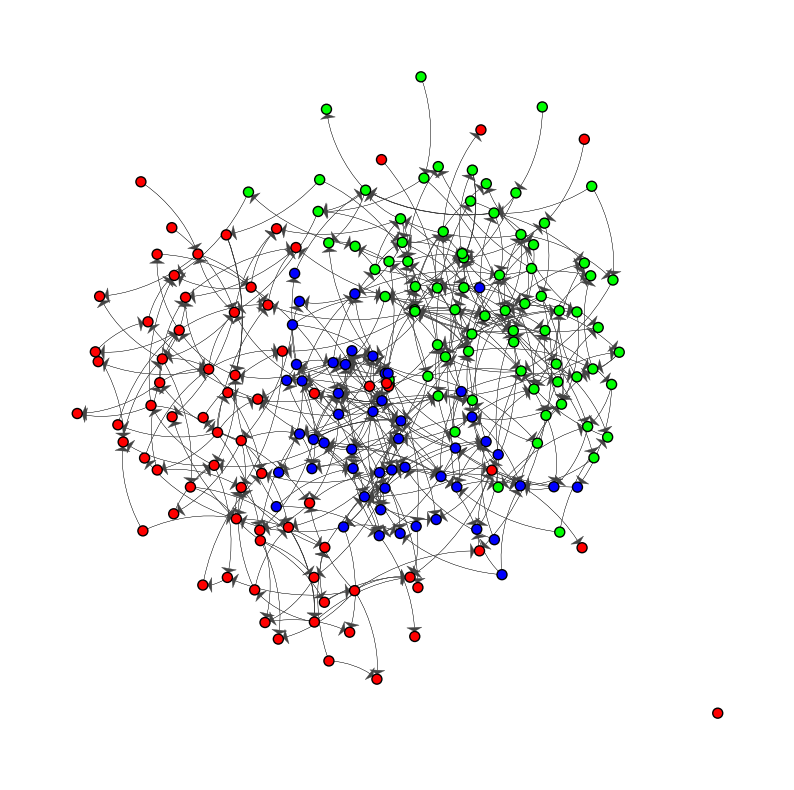

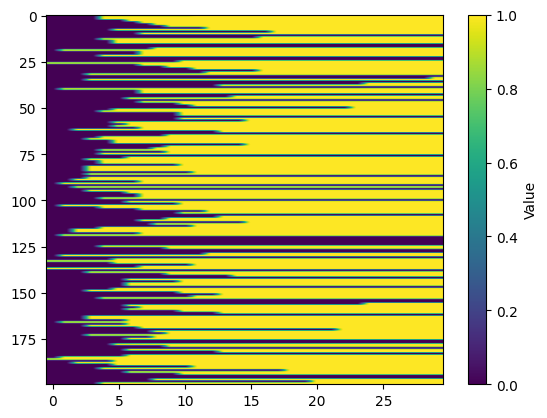

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:24<00:00, 80.33it/s, 3 steps of size 9.20e-01. acc. prob=0.89]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


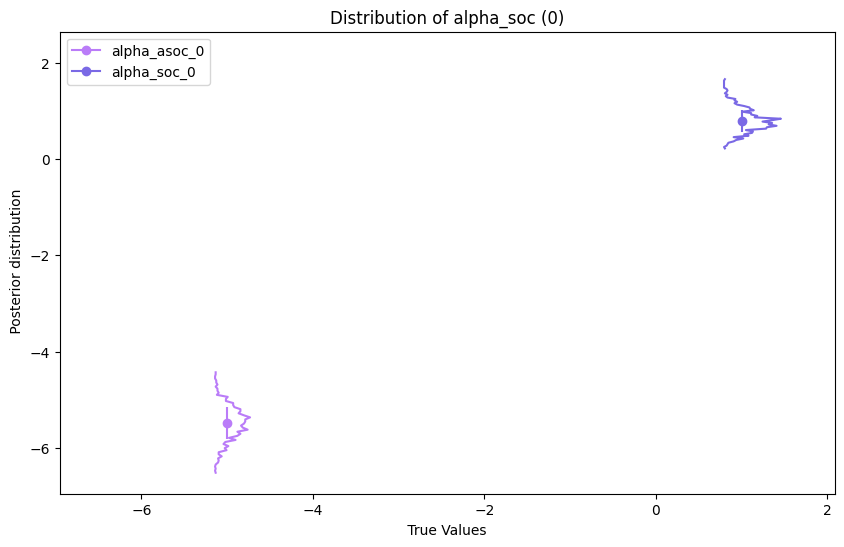

In [337]:
nbdaObject, means, m, covariates_data = main(N = 200, 
                                             times = 30,
                                             alpha_social = jnp.array([1]), 
                                             alpha_asocial = jnp.array([-5]),
                                             print_network= True, print_status = True)
plot_distributions(m.posteriors,  dict(alpha_asoc=jnp.array([-5]), alpha_soc=jnp.array([1])))

So the main simulation data will always have asocial rate set to -5 (nonexistent) and so social rate set to 1 (0.75).


In [15]:
def scale(x):
    return (x - x.mean()) / x.std()


### Nodal Fixed covariate

Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [04:08<00:00,  8.06it/s, 7 steps of size 4.25e-01. acc. prob=0.93] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -5.16  0.23     -5.55      -4.80       0.01     0.01    848.05   
alpha_soc[0]   0.92  0.32      0.42       1.39       0.01     0.01    706.06   
betas_asoc[0] -1.25  0.21     -1.57      -0.93       0.01     0.01    765.69   
betas_soc[0]   0.07  0.26     -0.31       0.49       0.01     0.01    797.31   
betas_soc[1]   0.13  0.30     -0.29       0.65       0.01     0.01   1033.82   

               ess_tail  r_hat  
alpha_asoc[0]    586.21    NaN  
alpha_soc[0]     408.30    NaN  
betas_asoc[0]    685.62    NaN  
betas_soc[0]     452.50    NaN  
betas_soc[1]     642.85    NaN  


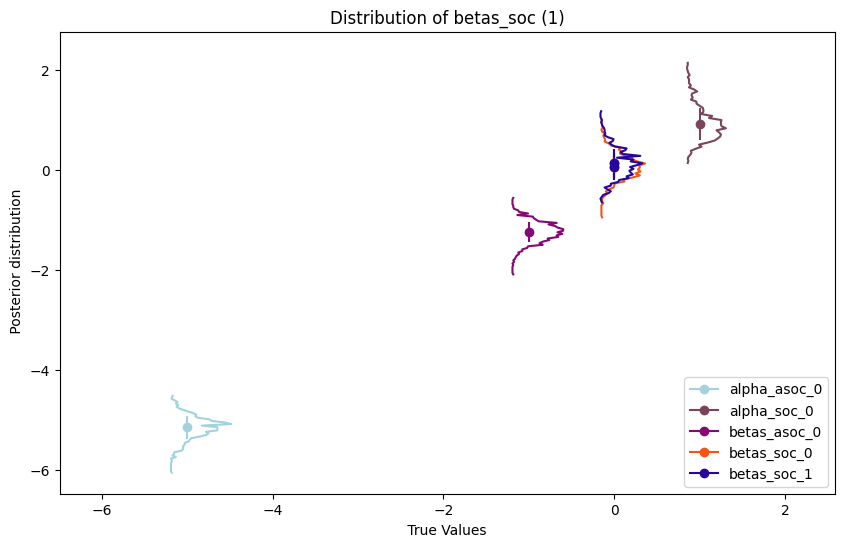

In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(scale(pd.DataFrame(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0 ]) #! covNF will have an effect of 0 (i.e. 0.5) we need 2 coefficients, one for covNF_i and one for covNF_j
alpha_asocial =jnp.array([-5, -1]) #! covNF will have an effect of -5 (i.e. noneexistent)
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(scale(pd.DataFrame(covariates_data['covF'])))
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]],       alpha_soc=[alpha_social[0]],
                                       betas_asoc =  alpha_asocial[1:], betas_soc = alpha_social[1:]), by_param = False)

### Nodal time varying covariate

Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [20:08<00:00,  1.21s/it, 31 steps of size 1.06e-01. acc. prob=0.94] 
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -3.39  0.94     -4.90      -1.96       0.08     0.05    149.48   
alpha_soc[0]   1.50  2.88     -2.45       6.39       0.19     0.18    251.12   
betas_asoc[0] -2.85  0.45     -3.51      -2.15       0.03     0.02    285.41   
betas_asoc[1] -2.87  0.52     -3.63      -2.05       0.04     0.03    168.18   
betas_soc[0]  -0.01  1.01     -1.33       1.95       0.05     0.04    436.86   
betas_soc[1]   0.19  0.79     -0.97       1.55       0.04     0.04    335.52   
betas_soc[2]   0.02  1.02     -1.65       1.62       0.05     0.05    408.05   
betas_soc[3]  -0.18  1.06     -1.72       1.62       0.05     0.05    390.90   

               ess_tail  r_hat  
alpha_asoc[0]    250.18    NaN  
alpha_soc[0]     201.22    NaN  
betas_asoc[0]    221.44    NaN  
betas_asoc[1]    201.28    NaN  
betas_soc[0]     299.66    NaN  
betas_soc[1]     260.76    NaN  
betas_soc[2]     335.32    

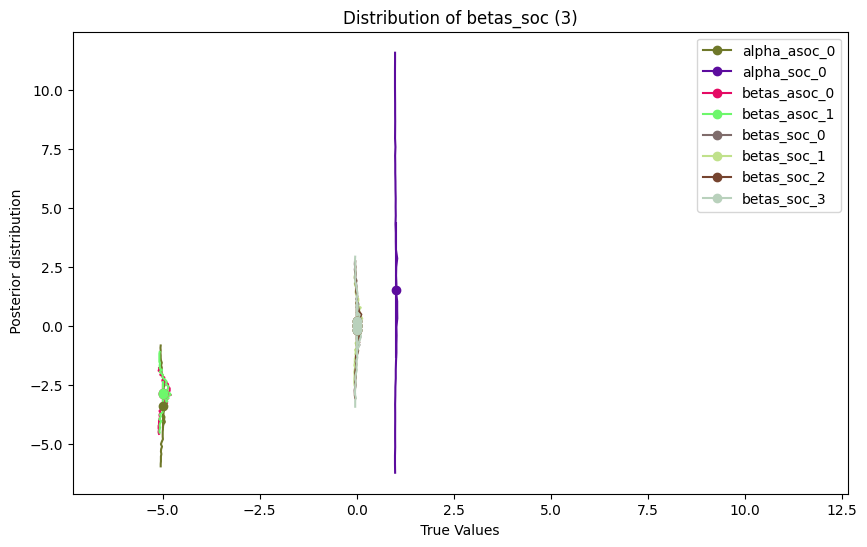

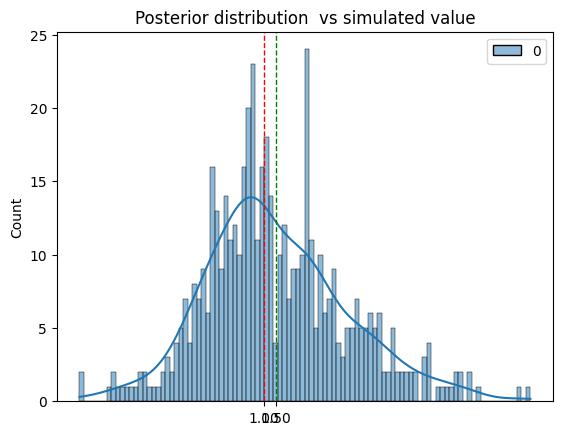

In [94]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.import_covNV(scale(covariates_data['covV'][:,:times].reshape((-1,N,times)))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0, 0, 0 ]) #! covNF will have an effect of 0 (i.e. 0.5) we need 2 coefficients, one for covNF_i and one for covNF_j
alpha_asocial =jnp.array([-5, -5, -5]) #! covNF will have an effect of -5 (i.e. noneexistent)
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
nbda.import_covNV(scale(covariates_data['covV'][:,:times].reshape((-1,N,times)))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

## Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], betas_asoc=alpha_asocial[1:],
                                       alpha_soc=[alpha_social[0]], betas_soc=alpha_social[1:]), by_param = False)

kde(m.posteriors['alpha_soc'],  original_value=alpha_social[0])


### QQ-plot

In [114]:
m.posteriors['betas_asoc'].shape

(500, 2)

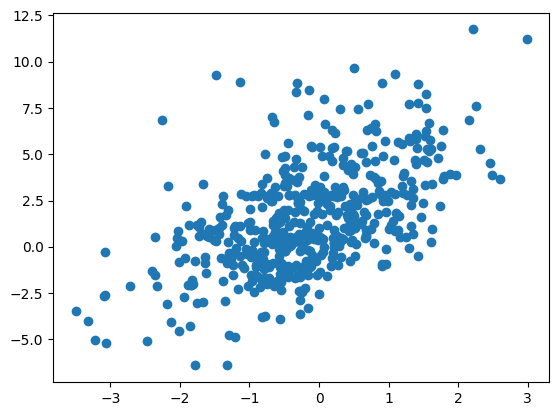

In [120]:
plt.scatter(m.posteriors['betas_soc'][:,3], m.posteriors['alpha_soc'])

alpha_asoc


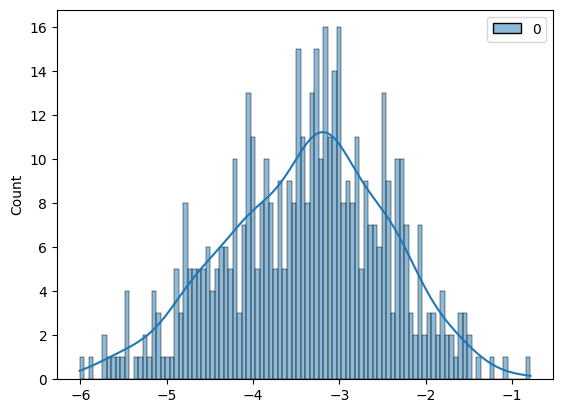

alpha_soc


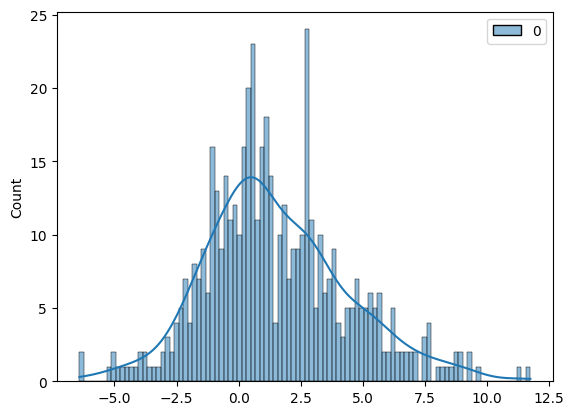

betas_asoc


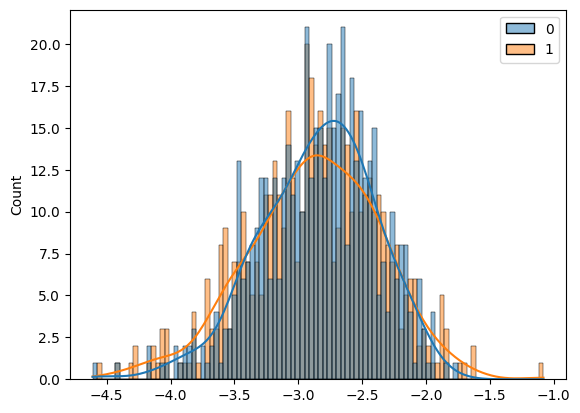

betas_soc


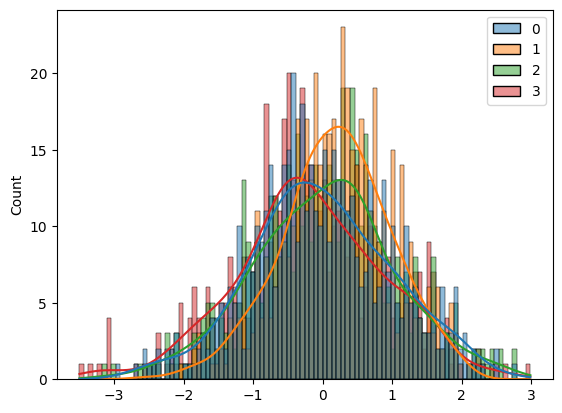

In [112]:
for k in m.posteriors.keys():
    print(k)
    sns.histplot(m.posteriors[k], kde=True, bins = 100)
    plt.show()
    plt.close()

<Axes: ylabel='Count'>

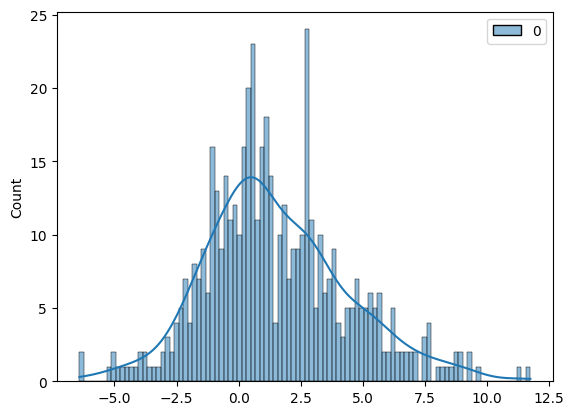

In [106]:
sns.histplot(m.posteriors['alpha_soc'], kde=True, bins = 100)

/tmp/ipykernel_79485/624485197.py:3: UserWarning: Sample's batch dimension size 500 is different from the provided 1000 num_samples argument. Defaulting to 500.
  predictive = Predictive(model, m.posteriors, num_samples=1000)


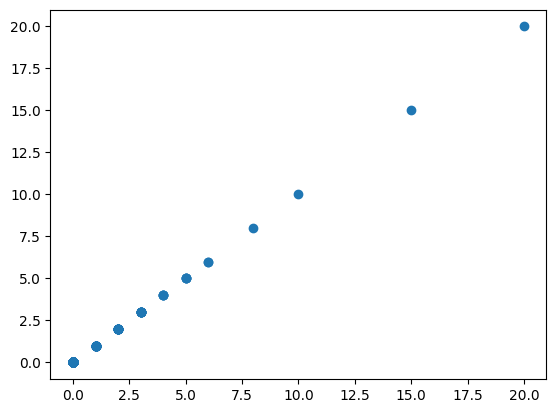

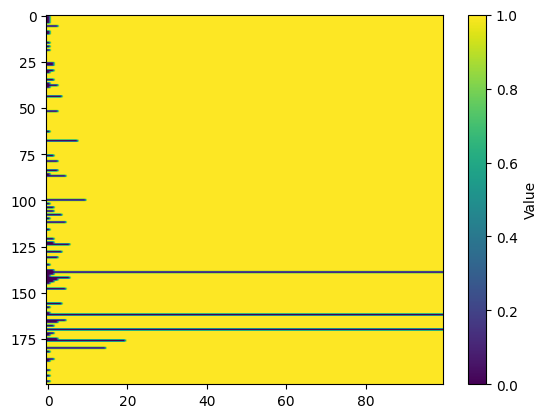

In [97]:
from numpyro.infer import Predictive
def predict(model, m, nbdaObject):
    predictive = Predictive(model, m.posteriors, num_samples=1000)
    rng_key = jax.random.PRNGKey(1)
    preds = predictive(rng_key, D_asocial = nbdaObject.D_asocial, D_social = nbdaObject.D_social, network = nbdaObject.network, status2 = nbdaObject.status)

    meanPred = jnp.mean(preds['y'][:,:,:,0], axis=0)
    plt.scatter(jnp.argmax(nbdaObject.status, axis=1)[:,0],
            jnp.argmax(meanPred, axis=1))
    plt.show()
    heatmap(meanPred)
    return preds
preds = predict(model, m, nbda)

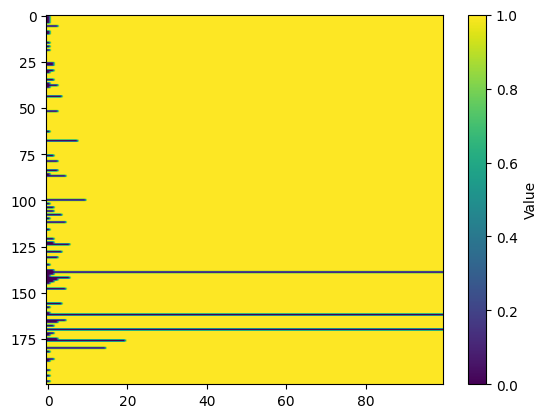

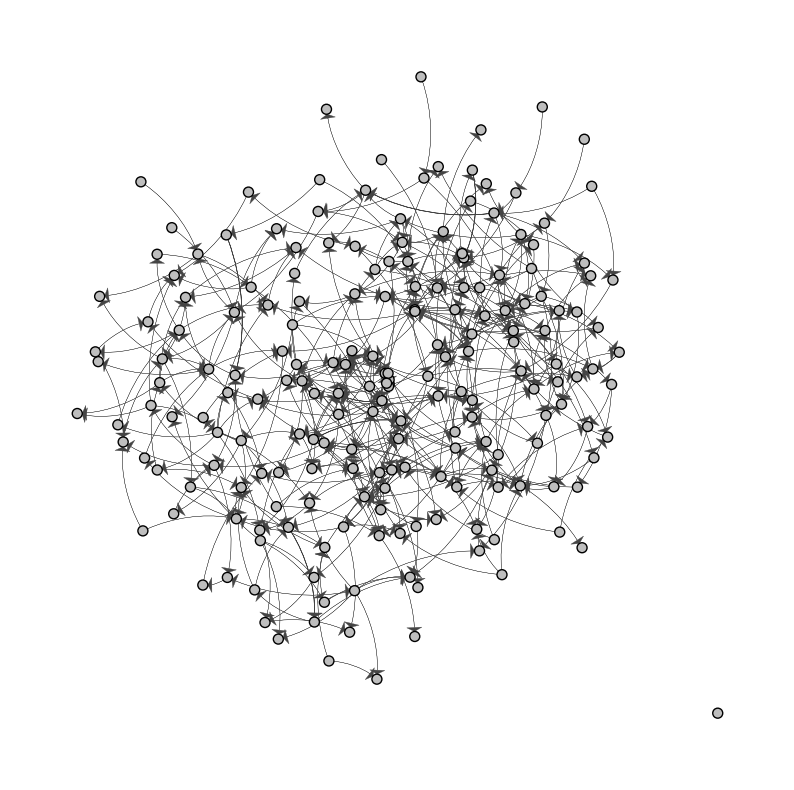

In [102]:
heatmap(nbda.status)
viz_network(nbda.network[:,:,0,0])

# [Constant elasticity of substitution](https://en.wikipedia.org/wiki/Constant_elasticity_of_substitution) to account for directionality and rate of learning based on network links

$Q = F \cdot \left( a \cdot K^\rho + (1 - a) \cdot L^\rho \right)^{\frac{\nu}{\rho}}$

where: 

- Q = Quantity of output

- F = Total Factor Productivity

- a = Share parameter

- K,L = Quantities of primary production factors (Capital and Labor)
 
- ρ = (σ − 1)/σ = Substitution parameter

- σ = 1/(1 - ρ) = [Elasticity of substitution](https://en.wikipedia.org/wiki/Elasticity_of_substitution)

- υ = degree of homogeneity of CES function. Where v = 1 (Constant return to scale),  υ  < 1 (Decreasing return to scale), υ > 1 (Increasing return to scale).


In [ ]:
@jax.jit
def ces(network, a, sigma, v):
    """
    Compute Constant elasticity of substitution (CES):
        Q = (a * K**rho + (1 - a) * L**rho)**(v/rho)
    
    Parameters:
      network (2D array): network where rows represent outgoing ties and coulmns incoming ties.
      a (float):  Share parameter
      v (float): = degree of homogeneity of CES function. Where v = 1 (Constant return to scale),  υ  < 1 (Decreasing return to scale), υ > 1 (Increasing return to scale).
      rho (float): Substitution parameter
    Returns:
      float: The computed output from the CES production function.
    """ 

    K = network
    L = network.T
    rho = (sigma - 1)/sigma
    return (a * K**rho + (1 - a) * L**rho)**(v/rho) # ! I add to remove v as I do not understand it

net = create_random_network(5)
print("original network ---------")
print(net)

# if a, v and sigma are = 1 we should network
print("\n network---------")
print(ces(net, a = 1, v = 1, sigma = 1))

# if a = 0.5, and v and sigma are = 1 we should get network/2 + network.T/2
print("\n network/2 + network.T/2---------")
print(ces(net, a = 0.5, v = 1, sigma = 1))

# if a = 0, and v and sigma are = 1 we should get network.T
print("\n network.T---------")
print(ces(net, a = 0, v = 1, sigma = 1))

# Sigma is giving scaling incoming (as it reach 0) or outgoing (as it reach infinity), so it is a paramter that give information on directionality importance for soicla transmision
print("\n binary network---------")
print(ces(net, a = 1, v = 1, sigma =0.00001)) 

# V is link weigths scale parameter as it increase it increase effect of links weigths and as it reach zero it concider only presence or abscence
# !How to get network + network.T ?


original network ---------
[[0 0 0 0 0]
 [0 0 0 0 2]
 [0 2 0 0 0]
 [0 0 0 0 0]
 [0 0 2 0 0]]

 network---------
[[0 0 0 0 0]
 [0 0 0 0 2]
 [0 2 0 0 0]
 [0 0 0 0 0]
 [0 0 2 0 0]]

 network/2 + network.T/2---------
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0.]]

 network.T---------
[[0 0 0 0 0]
 [0 0 2 0 0]
 [0 0 0 0 2]
 [0 0 0 0 0]
 [0 2 0 0 0]]

 binary network---------
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
